# Covid-19, Time To Get Out?

![alt text](man_window_covid.jpg "Title")

## Table of Contents
<ul>
<li><a href="#contact">Contact Information</a></li> 
<p>
<li><a href="#business">1. Business Understanding</a></li> 
<li style="margin-left: 40px"><a href="#q1">Q1: Who are the best and worst countries dealing with Covid-19?</a></li> 
<li style="margin-left: 40px"><a href="#q2">Q2: Which countries have flattened or are flattening the curve?</a></li>
<li style="margin-left: 40px"><a href="#q3">Q3: Can I see a global geographic representation of infections?</a></li>
<li style="margin-left: 40px"><a href="#q4">Q4: What is the projected global mortality by December 31, 2020?</a></li> 
<p>
<li><a href="#data">2. Data Understanding</a></li> 
<li style="margin-left: 40px"><a href="#gather">Gather</a></li>
<li style="margin-left: 40px"><a href="#describe">Describe, Clean, Explore, and Verify</a></li>
<p>
<li><a href="#data_prep">3. Data Preparation</a></li> 
<li style="margin-left: 40px"><a href="#a1">Answer To Q1</a></li>    
<li style="margin-left: 40px"><a href="#a2">Answer To Q2</a></li>    
<li style="margin-left: 40px"><a href="#a3">Answer To Q3</a></li> 
<li style="margin-left: 40px"><a href="#a4">Answer To Q4</a></li>
<p>
<li><a href="#model">4. Model Data</a></li>
<li style="margin-left: 40px"><a href="#a4">Answer To Q4</a></li>
<p>
<li><a href="#conclusions">5. Results and Conclusions</a></li>
<li style="margin-left: 40px"><a href="#limitations">Limitations</a></li>
<p>
<li><a href="#deploy">6. Deploy</a></li>
<p>

In [1]:
# import libraries

# ARIMA libraries
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
import warnings

# Global map visualization
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

# Regular libraries
from datetime import datetime, timedelta
import dateutil.parser
import geopandas as gpd
import glob
from IPython.display import Image
import json
import math
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import pandas as pd
import seaborn as sns

<a id='contact'></a>
## Contact Information

> - Lindsay Moir

<a id='business'></a>
## Business Understanding

> Covid-19 is a global pandemic. We have over 150 countries affected and many approaches to the pandemic. It is possible to use data science to evaluate the leadership of countries by using mortality as a litmus test. This notebook, collects the data necessary for that, graphically shows the results for those countries, and then also runs a machine learning model to predict the total mortality by the end of 2020 (global not by country). 

<a id='q1'></a>
### Question 1

#### Who are the best and worst countries in terms of per million population and wealth dealing with Covid-19?

We will  use people per million and median income as our metrics for this. An extremely small country would have a relatively small number of deaths and could be totally incompetent at managing covid. Whereas a large country (by population) could do a great job and still have a large number of deaths. Also we have included the Transparency International ranking. Many countries are manipulating their data.

<a id='q2'></a>
### Question 2

#### Which countries have flattened or are flattening the curve?

This will be defined as the number of New_Cases per day over the last 14 days. We take the last date that data is available and we see if the number of New_Cases is going down. We will do this with a scatter plot and a regression line that is fitted to the data.

<a id='q3'></a>
### Question 3

#### Can I see a global geographic representation of infections?

We want to see the data on a global map. This allows us to quickly see where the hot spots are. We also have additional features that we will be visualizing on these maps.

<a id='q4'></a>
### Question 4

#### What is the projected global mortality as of December 31, 2020?

We will use 2 algorithms for this. One is a simply trigonometric model based on a regression line. The other is a more sophisticated ARIMA model which is ideal for predicting time series.

<a id='data'></a>
## Data Understanding

<a id='gather'></a>
### Gather

- I am using data from John Hopkins University. There is a GitHub repository that holds this data.  To refresh it just go to https://github.com/CSSEGISandData/COVID-19 and hit the Clone of download button. It will ask to launch GitHub Desktop and will update it automatically.
- The data for median income and population comes from https://worldpopulationreview.com/countries/median-income-by-country/
- World Bank Country Codes comes from https://wits.worldbank.org/wits/wits/witshelp/content/codes/country_codes.htm
- The Transparency International Dataset comes from https://www.transparency.org/cpi2019

#### John Hopkins Covid-19 Data

The columns change over time. I need to figure out what the super set of these column names are. Use glob and sets and a loop to create this result.

In [2]:
path = r'C:\Users\linds\OneDrive\mystuff\GitHub\COVID-19\csse_covid_19_data\csse_covid_19_daily_reports'
all_files = glob.glob(path + "/*.csv")

li_set = {}

for filename in all_files:
    df = pd.read_csv(filename)
    cols = df.columns
    cols = set(cols)
    li_set = cols.union(li_set)

print(li_set)

{'Combined_Key', 'Country_Region', 'Latitude', 'FIPS', 'Confirmed', 'Active', 'Case-Fatality_Ratio', 'Admin2', 'Longitude', 'Incidence_Rate', 'Last_Update', 'Province_State', 'Deaths', 'Last Update', 'Lat', 'Long_', 'Recovered', 'Country/Region', 'Province/State'}


In [3]:
# We want the LAST dfs column names
all_df_cols = df.columns
all_df_cols

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio'],
      dtype='object')

li_set is the superset of all column names. So, it is NOT the same as the last csv that I have. I have to do some renaming with every csv that comes in. Now that we know that, we know what column names to change and now we can bring in the entire set of files and concatenate them.

In [4]:
def short_df(df, temp_df):
    """Takes the columns from the 'short df' and puts them in a temp df.
    This temp_df will later be put into a df with other columns."""
    
    # Pandas really does not like '/' or ' ' in a column name so ... time to rename
    df.rename(columns={'Province/State': 'Province_State', 
                       'Country/Region': 'Country_Region',
                       'Last Update': 'Last_Update',
                       'Latitude': 'Lat',
                       'Longitude': 'Long_'}, inplace=True)
    
    # Get the current_df columns
    cols = df.columns
    
    # For loop for putting the appropriate columns in temp_df
    for col in cols:
        temp_df[col] = df[col]
        
    return temp_df

In [5]:
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    
    # Read in the next csv
    df = pd.read_csv(filename)
    
    # Get the date of the file
    date_string = filename[-14:-4]
    
    # Insert the date_string into the first column of the df
    df.insert(0, "Date_", date_string) 
    
    # If it is a full df then just append it
    if df.shape[1] == 13:
        li.append(df)
    
    else:
        # Need to build a df that is the same number of columns as the largest df (last one)
        # Create a temp_df to hold everything
        temp_df = pd.DataFrame(data=np.nan, columns=all_df_cols.insert(0, 'Date_'), index=df.index)
        
        # Call function to create the short_df
        df = short_df(df, temp_df)

        # append df to li
        li.append(df)

all_df = pd.concat(li)
all_df.shape

(496089, 15)

In [6]:
# reset the index
all_df.reset_index(inplace=True, drop=True)

# Convert Date_ column to date
all_df['Date_'] =  pd.to_datetime(all_df['Date_'], infer_datetime_format=True)
all_df.head()

Date_  FIPS Admin2 Province_State  Country_Region      Last_Update  \
0 2020-01-22   NaN    NaN          Anhui  Mainland China  1/22/2020 17:00   
1 2020-01-22   NaN    NaN        Beijing  Mainland China  1/22/2020 17:00   
2 2020-01-22   NaN    NaN      Chongqing  Mainland China  1/22/2020 17:00   
3 2020-01-22   NaN    NaN         Fujian  Mainland China  1/22/2020 17:00   
4 2020-01-22   NaN    NaN          Gansu  Mainland China  1/22/2020 17:00   

   Lat  Long_  Confirmed  Deaths  Recovered  Active Combined_Key  \
0  NaN    NaN        1.0     NaN        NaN     NaN          NaN   
1  NaN    NaN       14.0     NaN        NaN     NaN          NaN   
2  NaN    NaN        6.0     NaN        NaN     NaN          NaN   
3  NaN    NaN        1.0     NaN        NaN     NaN          NaN   
4  NaN    NaN        NaN     NaN        NaN     NaN          NaN   

   Incidence_Rate  Case-Fatality_Ratio  
0             NaN                  NaN  
1             NaN                  NaN  
2             NaN                  NaN  
3             NaN                  NaN  
4             NaN                  NaN

#### Get the date of the last row in the file to establish the currency of the data.

In [7]:
print(f'The "data date" is {all_df["Date_"].iloc[-1]}')

The "data date" is 2020-08-08 00:00:00


#### Population and MedianPerCapitaIncome

Now we need population and medium income data. This has been placed on disk in the local directory.

In [8]:
# Read in population and income data
pop_med_income_df = pd.read_csv(r'data/pop_med_income.csv')
pop_med_income_df.rename({"MedianPerCapitaIncome": 'MPC_Inc'}, axis=1, inplace=True)
pop_med_income_df.head()

Country_Region  MPC_Inc   Pop2020
0     Luxembourg    18418    625978
1         Norway    19308   5421241
2         Sweden    18632  10099265
3      Australia    15026  25499884
4        Denmark    18262   5792201

In [9]:
pop_med_income_df.dtypes

Country_Region    object
MPC_Inc            int64
Pop2020            int64
dtype: object

#### Country Codes

I had an already existing data file that I had originally gotten from World Bank https://wits.worldbank.org/wits/wits/witshelp/content/codes/country_codes.htm. I have added items to it since, the names of the countries keep on changing in the different datasets that I encounter. Eventually this should be bullet proof. Some data munging was required on this. The John Hopkins data does not have an ISO standard Country column. 

In [10]:
# Now we want to add a country code
country_codes_df = pd.read_csv(r'data/country_codes_edited.csv')
country_codes_df.head()

Country_Region ISO3166-1-Alpha-2 ISO3166-1-Alpha-3  ISO3166-1-numeric
0          Aruba                AW               ABW              533.0
1    Afghanistan                AF               AFG                4.0
2         Angola                AO               AGO               24.0
3       Anguilla                AI               AIA              660.0
4  Aland Islands                AX               ALA              248.0

In [11]:
# Lets rename the 3 letter code column
country_codes_df.rename({'ISO3166-1-Alpha-3': 'Alpha_3'}, axis=1, inplace =True)
country_codes_df.head(1)

Country_Region ISO3166-1-Alpha-2 Alpha_3  ISO3166-1-numeric
0          Aruba                AW     ABW              533.0

In [12]:
# We only want Country_Region and Alpha-3
country_codes_df = country_codes_df[['Country_Region', 'Alpha_3']]
country_codes_df.head(1)

Country_Region Alpha_3
0          Aruba     ABW

#### Transparency International

One of the huge issues with the covid-19 data is there are lots of politics being played with the numbers by politicians. We will use the Transparency International https://www.transparency.org/cpi2019 data 2019 to give us an inkling of whether or not we can trust the numbers.

In [13]:
trans_int_df = pd.read_csv(r'data/transparency_international.csv')
trans_int_df.head()

Alpha_3  TI_2019
0     DNK       87
1     NZL       87
2     FIN       86
3     SGP       85
4     SWE       85

In [14]:
# Merge the two dfs (country_codes_df and pop_med_income_df)
pop_inc_cc_codes = country_codes_df.merge(pop_med_income_df)
pop_inc_cc_codes.head()

Country_Region Alpha_3  MPC_Inc   Pop2020
0    Afghanistan     AFG      378  38928346
1         Angola     AGO      720  32866272
2        Albania     ALB     1902   2877797
3      Argentina     ARG     4109  45195774
4        Armenia     ARM      926   2963243

In [15]:
# Merge the two dfs (country_codes_df and pop_med_income_df)
pop_inc_cc_codes = pop_inc_cc_codes.merge(trans_int_df)

In [16]:
pop_inc_cc_codes.head()

Country_Region Alpha_3  MPC_Inc   Pop2020  TI_2019
0    Afghanistan     AFG      378  38928346       16
1         Angola     AGO      720  32866272       26
2        Albania     ALB     1902   2877797       35
3      Argentina     ARG     4109  45195774       45
4        Armenia     ARM      926   2963243       42

We will merge this dataframe with the all_df after we have done some aggregations with all_df. However, right now we need to go to the next step which is to describe the data.

<a id='describe'></a>
### Describe, Clean, Explore, and Verify

In [17]:
all_df.describe()

FIPS            Lat          Long_      Confirmed  \
count  419696.000000  484249.000000  484249.000000  496070.000000   
mean    31428.964655      36.240503     -75.466104    2109.631052   
std     17140.271412      11.920925      49.156663   13767.806288   
min        66.000000     -52.368000    -174.159600       0.000000   
25%     18165.000000      33.613005     -96.265228       9.000000   
50%     29186.000000      37.924657     -87.358917      58.000000   
75%     46073.000000      41.809386     -79.446059     365.000000   
max     99999.000000      72.000000     178.065000  621731.000000   

              Deaths     Recovered        Active  Incidence_Rate  \
count  495648.000000  4.957010e+05  4.883450e+05   268256.000000   
mean      103.893089  1.058021e+03  9.287632e+02      560.950765   
std      1004.103921  1.481227e+04  1.681211e+04      807.558971   
min         0.000000  0.000000e+00 -2.444330e+06        0.000000   
25%         0.000000  0.000000e+00  5.000000e+00      110.677121   
50%         1.000000  0.000000e+00  4.400000e+01      292.348245   
75%        10.000000  0.000000e+00  2.800000e+02      688.963582   
max     41940.000000  1.643118e+06  2.490150e+05    14019.851117   

       Case-Fatality_Ratio  
count        269826.000000  
mean              3.265112  
std              29.256235  
min               0.000000  
25%               0.000000  
50%               1.515152  
75%               4.166667  
max            5500.000000

The above are all of the numeric columns. For our analysis we can drop FIPS, Recovered, and Active. We will keep the balance of the numeric columns. We have put a record of this in the todos in the Clean section.

In [18]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496089 entries, 0 to 496088
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date_                496089 non-null  datetime64[ns]
 1   FIPS                 419696 non-null  float64       
 2   Admin2               420584 non-null  object        
 3   Province_State       468464 non-null  object        
 4   Country_Region       496089 non-null  object        
 5   Last_Update          496089 non-null  object        
 6   Lat                  484249 non-null  float64       
 7   Long_                484249 non-null  float64       
 8   Confirmed            496070 non-null  float64       
 9   Deaths               495648 non-null  float64       
 10  Recovered            495701 non-null  float64       
 11  Active               488345 non-null  float64       
 12  Combined_Key         488472 non-null  object        
 13  Incidence_Rate

#### Define

Check for duplicates now.

In [19]:
# Test
all_df.duplicated().sum()

0

Excellent no duplicates!

#### Define

We will also drop Admin2, Province_State, Last_Update, and Combined_Key. We are doing everything with Country. We have put a record of this in the todos in the Clean section. However, in order to use our time efficiently as we are describing the data, we will drop these columns now. There is no sense describing columns that you are dropping.

In [20]:
# Code

# Make a copy to avoid the inevitable Pandas warnings.
slim_df = all_df.copy(deep=True)

# Just keep the columns we want.
slim_df = slim_df[['Date_', 'Country_Region', 'Lat', 'Long_', 'Confirmed', 'Deaths']]

# Test
slim_df.head(1)

Date_  Country_Region  Lat  Long_  Confirmed  Deaths
0 2020-01-22  Mainland China  NaN    NaN        1.0     NaN

In [21]:
# Null status
slim_df.isnull().mean()

Date_             0.000000
Country_Region    0.000000
Lat               0.023867
Long_             0.023867
Confirmed         0.000038
Deaths            0.000889
dtype: float64

#### Define

Add fill backwards to the clean section. There are a few missing values. Need to deal with this now so that we can look at data distribution.

In [22]:
# Code
slim_df = slim_df.bfill()

In [23]:
# Test
# Null status
slim_df.isnull().mean()

Date_             0.0
Country_Region    0.0
Lat               0.0
Long_             0.0
Confirmed         0.0
Deaths            0.0
dtype: float64

Excellent no nulls!

In [24]:
slim_df.describe()

Lat          Long_      Confirmed         Deaths
count  496089.000000  496089.000000  496089.000000  496089.000000
mean       36.200558     -74.247058    2109.555685     103.872952
std        12.010588      50.888040   13767.548096    1003.661087
min       -52.368000    -174.159600       0.000000       0.000000
25%        33.604253     -96.107511       9.000000       0.000000
50%        37.786361     -86.879242      58.000000       1.000000
75%        41.755097     -79.333533     365.000000      10.000000
max        72.000000     178.065000  621731.000000   41940.000000

As you can tell from the .describe() method this is essentially a dataframe of outliers. We are just trying to see the spread, so ... we can be creative. 

In [25]:
slim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496089 entries, 0 to 496088
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Date_           496089 non-null  datetime64[ns]
 1   Country_Region  496089 non-null  object        
 2   Lat             496089 non-null  float64       
 3   Long_           496089 non-null  float64       
 4   Confirmed       496089 non-null  float64       
 5   Deaths          496089 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 22.7+ MB


In [26]:
# Get the numeric columns
cols = slim_df.select_dtypes('float').columns
cols

Index(['Lat', 'Long_', 'Confirmed', 'Deaths'], dtype='object')

In [27]:
# Get rid of all of the row that are all zeros
no_zeros_df = slim_df[(slim_df[cols].T != 0).all()]
print(no_zeros_df.shape)
no_zeros_df

(284756, 6)


Date_      Country_Region        Lat       Long_  Confirmed  \
0      2020-01-22      Mainland China  30.975600  112.270700        1.0   
1      2020-01-22      Mainland China  30.975600  112.270700       14.0   
2      2020-01-22      Mainland China  30.975600  112.270700        6.0   
3      2020-01-22      Mainland China  30.975600  112.270700        1.0   
4      2020-01-22      Mainland China  30.975600  112.270700       26.0   
...           ...                 ...        ...         ...        ...   
496078 2020-08-08  West Bank and Gaza  31.952200   35.233200    13928.0   
496079 2020-08-08      Western Sahara  24.215500  -12.885800       10.0   
496080 2020-08-08               Yemen  15.552727   48.516388     1797.0   
496081 2020-08-08              Zambia -13.133897   27.849332     7903.0   
496082 2020-08-08            Zimbabwe -19.015438   29.154857     4575.0   

        Deaths  
0         17.0  
1         17.0  
2         17.0  
3         17.0  
4         17.0  
...        ...  
496078    96.0  
496079     1.0  
496080   512.0  
496081   203.0  
496082   102.0  

[284756 rows x 6 columns]

Now we can run some boxplots (below) since we will not have divide by 0 errors.

In [28]:
no_zeros_df.describe()

Lat          Long_      Confirmed         Deaths
count  284756.000000  284756.000000  284756.000000  284756.000000
mean       35.027733     -66.507686    3638.882643     180.814782
std        13.366560      56.004136   17992.476463    1319.466315
min       -52.368000    -157.971218       1.000000       1.000000
25%        32.564838     -92.414197      72.000000       2.000000
50%        37.035138     -84.490894     253.000000       7.000000
75%        41.344261     -76.215079    1134.000000      32.000000
max        71.706900     178.065000  621731.000000   41940.000000

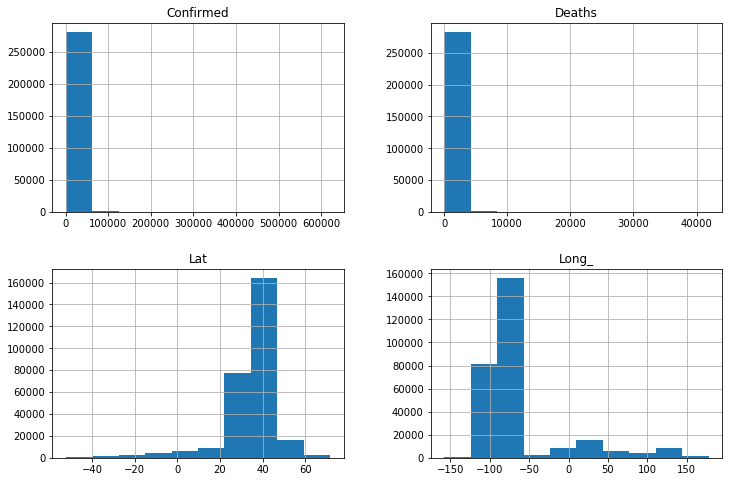

In [29]:
no_zeros_df.hist();

In [30]:
# Lets create a log10 of Confirmed and Deaths
log10_df = no_zeros_df[cols]
log10_df = np.log10(log10_df)

C:\Users\linds\Anaconda3\envs\sklearn\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


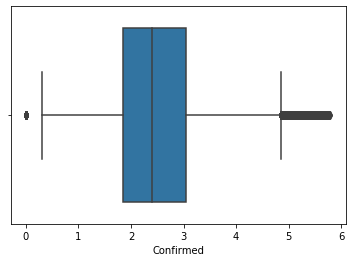

In [31]:
# Now plot Confirmed
plt.figure(figsize=(6, 4))
sns.boxplot(x=log10_df['Confirmed'])

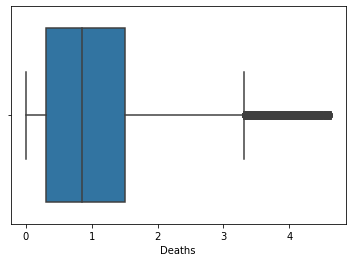

In [32]:
# Now plot Deaths
plt.figure(figsize=(6, 4))
sns.boxplot(x=log10_df['Deaths'])

As expected, no real insightful information to be gained from this.

#### Summary of Cleaning Issues

all_df
- We will need several versions of dataframes. Each question requires slightly different data to drive the result.
- There are nulls in all_df that we have filled backwards. The reason that we fill backwards is that we think that the reporting is slow. This is a time series. Filling backwards is close to the best value that we could get if not the best.

country_codes_df
- This has been data wrangled to successfully merge with all_df on the Country_Region column. 

pop_med_income_df
- This was data wrangled and should yield no issues while merging with all_df on the Country_Region column. Thereafter we will use the Alpha_3 column.

trans_int_df
- This dataset is clean and does not require any wrangling.

<a id='data_prep'></a>
## Data Preparation

As we go thru this notebook we will be transforming the data so that we can answer the questions posed. To start lets look at some global visualizations.

In [33]:
def plot_confirmed_death(df, place):
    """Plots daily running total of confirmed cases and deaths"""

    start = df.index[0].strftime('%Y-%m-%d')
    end = df.index[-1].strftime('%Y-%m-%d')
    title = ('From {} to {} Daily Running Total Statistics For Covid-19 ({})').format(start, end, place)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('# Of Cases and Deaths Per Day')
    plt.plot('Confirmed', data=df, color='orange', linewidth=2, label='Confirmed Cases')
    plt.plot('Deaths', data=df, linewidth=2, label='Deaths')
    plt.legend()
    plt.savefig(r'pics_final/running_totals.png');

In [34]:
def plot_mortality_rate(df, place):
    """Mortality rate plotted"""

    start = df.index[0].strftime('%Y-%m-%d')
    end = df.index[-1].strftime('%Y-%m-%d')
    title = ('From {} to {} Change in Mortality For Covid-19 ({})').format(start, end, place)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Mortality Rate')
    plt.plot('Mortality_Rate', data=df, linewidth=2, label='Deaths')
    plt.legend()
    plt.savefig(r'pics_final/mortality_rate.png');

In [35]:
def mortality_population(df, sign):
    """Plot the Deaths_e6. This is adjusted for population. It shows what countries are doing well or poorly
    considering their Median Income and Transparency International score"""
    
    sns.set_color_codes("pastel")
    sns.barplot(x="Deaths_e6", y="Country_Region", data=df,
                label="Deaths Per Million Population", palette="Blues_d")

    # Title
    title = ('Mortality Rate Per Million Population As of {}').format(end)
    plt.xlabel('Deaths Per Million')
    plt.title(title)
    
    # Construct legend
    legend_ = f'Includes Only Countries With {sign} 50% Median Per Capita Income and >= 60 on Transparency International Score'
    plt.legend([legend_])
    
    # Final housekeeping
    sns.despine(left=True, bottom=True)
    plt.savefig(r'pics_final/honest_but_no_money.png');

In [36]:
def regression_new_cases(df, place, days):
    """Number of New_Cases with Regression Line"""
    
    # Create the title
    end = df['Date_'].iloc[-1].strftime('%Y-%m-%d')
    title1 = (f'New Cases For Last {days} Days Prior To And Including {end} For Covid-19 With Regression Line ({place}) ')
    title2 = (f'\n{country} Has a Transparency International Score of {recent["TI_2019"].iloc[0]}')
    plt.title(title1 + title2)
    
    # We want the indexes in a list so we can place them on the x axis
    new_labels = df['Date_'].dt.strftime('%m-%d').tolist()
    plt.xticks(np.arange(len(new_labels)), new_labels)
    
    # Label the axis
    plt.xlabel('Consecutive Days')
    plt.ylabel('New_Cases Daily')
    
    # Create the plot
    sns.regplot(x=range(len(df)), y='New_Cases', data=df)
    
    # Create legend
    plt.legend(['New_Cases'], loc='upper center')
    
    plt.savefig(r'pics_final/' + place + '.jpg')
    plt.show();

In [37]:
def regression_deaths(df, place):
    """Number of Deaths with Regression Line"""
    
    # Get start and end times of df
    start = df.index[0].strftime('%Y-%m-%d')
    end = df.index[-1].strftime('%Y-%m-%d')
    
    # Format the title and labels
    title = ('From {} to {} Daily Mortality For Covid-19 ({})').format(start, end, place)
    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('# Of Deaths Per Day')
    
    # Plot regression line
    sns.regplot(x=range(len(df)), y='Deaths', data=df, label='Deaths')
    
    # Legend
    plt.legend()
    
    # Save the chart
    plt.savefig(r'pics_final/running_totals.png');

In [38]:
def plot_world_map(merged, values):
    """Maps features onto a global map for visualization purposes"""
    
    # unpack values
    feature, legend_string, title_string = values
    
    # Read data to json.
    merged_json = json.loads(merged.to_json())

    # Convert to String like object.
    json_data = json.dumps(merged_json)

    # Input GeoJSON source that contains features for plotting.
    geosource = GeoJSONDataSource(geojson = json_data)

    # Define a sequential multi-hue color palette.
    palette = brewer['YlGnBu'][8]

    # Reverse color order so that dark blue is highest obesity.
    palette = palette[::-1]

    # Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, 
                                     low = 0, 
                                     high = 1, 
                                     nan_color = '#d9d9d9')

    # Define custom tick labels for color bar.
    tick_labels = {'0': legend_string}

    # Create color bar. 
    color_bar = ColorBar(color_mapper=color_mapper, 
                         label_standoff = 8, 
                         width = 500, height = 20,
                         border_line_color = None, 
                         location = (0,0), 
                         orientation = 'horizontal', 
                         major_label_overrides = tick_labels)

    # Create figure object.
    p = figure(title = title_string,
               plot_height = 600 , 
               plot_width = 950, 
               toolbar_location = None)

    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    # Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource, fill_color = {'field' : feature, 'transform' : color_mapper},
              line_color = 'black', line_width = 0.25, fill_alpha = 1)

    # Specify figure layout.
    p.add_layout(color_bar, 'below')

    # Display figure inline in Jupyter Notebook.
    output_notebook()

    # Display figure.
    show(p)

In [39]:
def predict_deaths(df, place):

    # Add a new column that is Deaths_e6 (deaths per million)
    forecast_df['Deaths_e6'] = forecast_df['Deaths'] / 1000000

    # Assemble title
    start = forecast_df.index[0].strftime('%Y-%m-%d')
    title = ('{} Forecast Cumulative Deaths In Millions For Covid-19 ({} to {})').format(place, start, forecast_date)
    plt.title(title)

    # Create x and y axis labels
    plt.xlabel('Date')
    plt.ylabel('Cumulative Deaths In Millions')

    # Create plot
    plt.plot('Deaths_e6', data=forecast_df, linewidth=4, label='Deaths')
    plt.legend()
    plt.savefig(r'pics_final/' + place + '_prediction.png');

In [40]:
def calc_angle(df, a):
    """Calculates the angle of the regression line"""
    
    # Getting the length of all 3 sides
    # a is visualized based on a regression line of April 30 2020. This may change (obviously)
    b = (df.index[-1] - df.index[0]).days # Length of the dataframe (x axis).
    c = math.sqrt(a**2 + b**2)  # calculate the hypotenuse
    
    # Calculate the tangent
    tan = math.atan(a/b)
    angle = math.degrees(tan)
    
    return angle

In [41]:
def calc_deaths(angle, start, end):
    """Calculates the number of deaths based on the angle generated from calc_angle and days calculated from dates"""
    
    # Calculate the number of days for b (x axis / adjacent)
    start = dateutil.parser.parse(start)
    end = dateutil.parser.parse(end)
    days_ = end - start
    days_ = days_.days
    
    # Calculate the number of deaths (height / opposite)
    deaths = days_ * (math.tan(math.radians(angle)))
    
    return int(deaths), days_

In [42]:
def place_value(number): 
    """Changes number to a readable number with ','s for 000s'"""
    
    return ("{:,}".format(number))

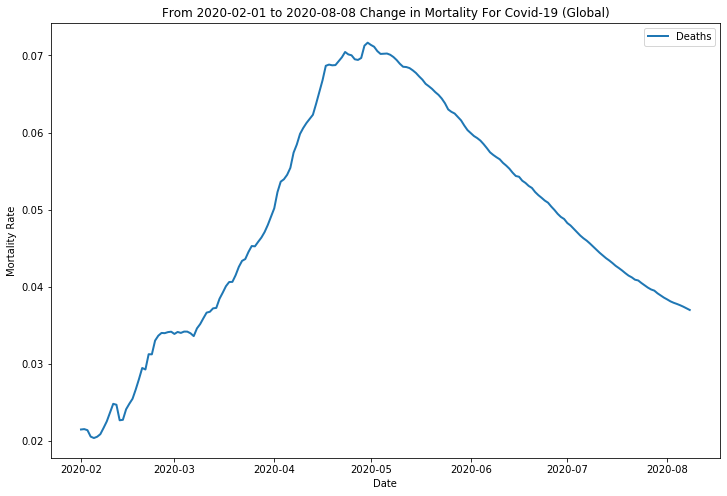

In [43]:
# Plot global mortality rate
global_df = slim_df.groupby('Date_').sum()
global_df = global_df[['Confirmed', 'Deaths']]
global_df['Mortality_Rate'] = global_df['Deaths'] / global_df['Confirmed']

# Clip outliers for mortality
global_df = global_df[global_df['Mortality_Rate'] <= .1]
plot_mortality_rate(global_df, 'Global')

It is extremely likely that the number of cases is at least 10 times higher than is being Confirmed. So, this mortality rate is likely 1/10 of the number shown here. 

In [44]:
global_df.describe()

Confirmed         Deaths  Mortality_Rate
count  1.900000e+02     190.000000      190.000000
mean   5.507822e+06  271018.489474        0.048659
std    5.681556e+06  237135.919373        0.014619
min    1.203800e+04     259.000000        0.020408
25%    2.500765e+05   10225.000000        0.037832
50%    3.709016e+06  260535.000000        0.047745
75%    9.062865e+06  471219.500000        0.061503
max    1.963751e+07  726781.000000        0.071661

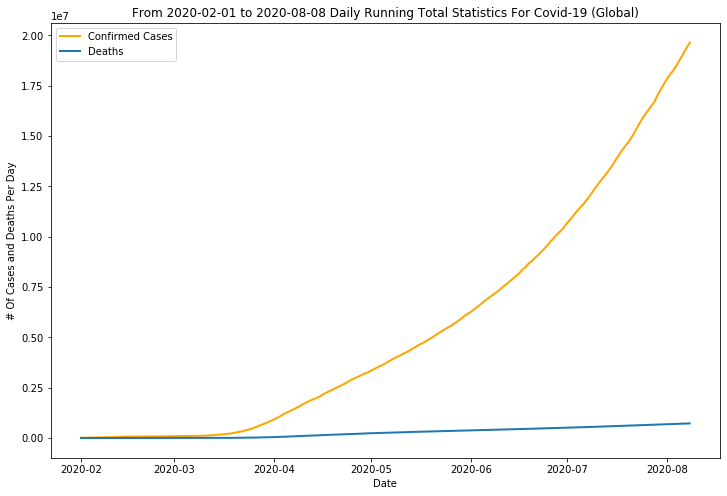

In [45]:
# Plot Confirmed and Deaths in one plot
plot_confirmed_death(global_df, 'Global')

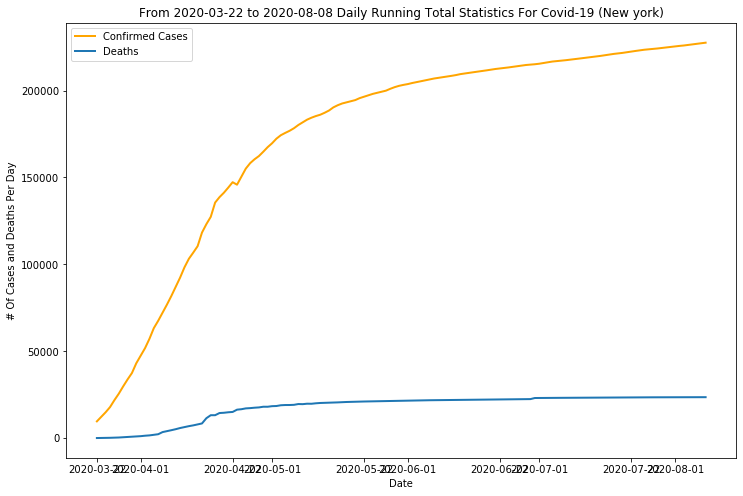

In [46]:
# Run plot for New York
new_york = all_df[all_df['Admin2'] == 'New York City'].copy(deep=True)
new_york.set_index('Date_', drop=True, inplace=True)
plot_confirmed_death(new_york, 'New york')

These are both VERY scary plots. They do not show any abatement or signs of flattening. If anything they have gone exponentially higher. 

### Question 1

Who are the best and worst countries dealing with Covid-19?

We need a dataframe that has these columns but we ONLY want the last date in the Covid-19 data. Then a groupby of that dataframe. Then to this dataframe we append Deaths_e6, Confirmed_e6,  Median_Income, and the Transparency International score.

In [47]:
# Now merge all_df with country_codes_df.
# First of all rename Country in country_codes_df to Country_Region to make the inner join simple
covid_pop_inc_df = all_df.merge(country_codes_df)
covid_pop_inc_df.head()

Date_  FIPS Admin2 Province_State  Country_Region      Last_Update  \
0 2020-01-22   NaN    NaN          Anhui  Mainland China  1/22/2020 17:00   
1 2020-01-22   NaN    NaN        Beijing  Mainland China  1/22/2020 17:00   
2 2020-01-22   NaN    NaN      Chongqing  Mainland China  1/22/2020 17:00   
3 2020-01-22   NaN    NaN         Fujian  Mainland China  1/22/2020 17:00   
4 2020-01-22   NaN    NaN          Gansu  Mainland China  1/22/2020 17:00   

   Lat  Long_  Confirmed  Deaths  Recovered  Active Combined_Key  \
0  NaN    NaN        1.0     NaN        NaN     NaN          NaN   
1  NaN    NaN       14.0     NaN        NaN     NaN          NaN   
2  NaN    NaN        6.0     NaN        NaN     NaN          NaN   
3  NaN    NaN        1.0     NaN        NaN     NaN          NaN   
4  NaN    NaN        NaN     NaN        NaN     NaN          NaN   

   Incidence_Rate  Case-Fatality_Ratio Alpha_3  
0             NaN                  NaN     CHN  
1             NaN                  NaN     CHN  
2             NaN                  NaN     CHN  
3             NaN                  NaN     CHN  
4             NaN                  NaN     CHN

In [48]:
len(covid_pop_inc_df)

496137

In [49]:
# Lets put covid_pop_inc_df on a diet
covid_pop_inc_df = covid_pop_inc_df[['Date_', 'Alpha_3', 'Country_Region', 'Lat', 'Long_', 'Confirmed', 'Deaths']]

In [50]:
covid_pop_inc_df.head()

Date_ Alpha_3  Country_Region  Lat  Long_  Confirmed  Deaths
0 2020-01-22     CHN  Mainland China  NaN    NaN        1.0     NaN
1 2020-01-22     CHN  Mainland China  NaN    NaN       14.0     NaN
2 2020-01-22     CHN  Mainland China  NaN    NaN        6.0     NaN
3 2020-01-22     CHN  Mainland China  NaN    NaN        1.0     NaN
4 2020-01-22     CHN  Mainland China  NaN    NaN        NaN     NaN

In [51]:
pop_inc_cc_codes.head(1)

Country_Region Alpha_3  MPC_Inc   Pop2020  TI_2019
0    Afghanistan     AFG      378  38928346       16

In [52]:
pop_inc_cc_codes.dtypes

Country_Region    object
Alpha_3           object
MPC_Inc            int64
Pop2020            int64
TI_2019            int64
dtype: object

In [53]:
covid_pop_inc_df.dtypes

Date_             datetime64[ns]
Alpha_3                   object
Country_Region            object
Lat                      float64
Long_                    float64
Confirmed                float64
Deaths                   float64
dtype: object

In [54]:
covid_pop_inc_df.head(1)

Date_ Alpha_3  Country_Region  Lat  Long_  Confirmed  Deaths
0 2020-01-22     CHN  Mainland China  NaN    NaN        1.0     NaN

In [55]:
q1_df = covid_pop_inc_df.groupby(['Date_','Alpha_3'], as_index=False)['Confirmed', 'Deaths'].sum()
end = q1_df.iloc[-1,0].strftime('%Y-%m-%d')
end

C:\Users\linds\Anaconda3\envs\sklearn\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


'2020-08-08'

In [56]:
q1_df = q1_df[q1_df['Date_'] == end]
print(q1_df.shape)
q1_df.head(1)

(184, 4)


Date_ Alpha_3  Confirmed  Deaths
29005 2020-08-08     AFG    37054.0  1312.0

In [57]:
# Now we want to merge the population and median income data with this.
q1_df = q1_df.merge(pop_inc_cc_codes)
q1_df.head(1)

Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc   Pop2020  \
0 2020-08-08     AFG    37054.0  1312.0    Afghanistan      378  38928346   

   TI_2019  
0       16

In [58]:
# Now convert Confirmed and Deaths to a rate per million population
q1_df['Confirmed_e6'] = q1_df['Confirmed'] / (q1_df['Pop2020'] / 1000000)
q1_df['Deaths_e6'] = q1_df['Deaths'] / (q1_df['Pop2020'] / 1000000)
q1_df.head(1)

Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc   Pop2020  \
0 2020-08-08     AFG    37054.0  1312.0    Afghanistan      378  38928346   

   TI_2019  Confirmed_e6  Deaths_e6  
0       16    951.851384  33.702947

In [59]:
# Make a copy of this df
q1_df_c = q1_df.copy(deep=True)

We do not think the reporting is correct for countries that are very poor. We are restricting our analysis to just the top 50% of all countries based on MedianPerCapitaIncome AND the country must have a Transparency International rating of 60 or over. The USA has a rating of 69. 

In [60]:
q1_df = q1_df[q1_df['TI_2019'] >= 60]
q1_median_income = int(q1_df['MPC_Inc'].median())
q1_df = q1_df[q1_df['MPC_Inc'] >= q1_median_income]
q1_df.sort_values('Deaths_e6', inplace=True)
print(q1_df.shape)
q1_df.head()

(14, 10)


Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc   Pop2020  \
83 2020-08-08     NZL     1569.0    22.0    New Zealand    12147   4822233   
5  2020-08-08     AUS    21084.0   295.0      Australia    15026  25499884   
81 2020-08-08     NOR     9599.0   256.0         Norway    19308   5421241   
37 2020-08-08     FIN     7568.0   331.0        Finland    15725   5540720   
6  2020-08-08     AUT    21919.0   721.0        Austria    12284   9006398   

    TI_2019  Confirmed_e6  Deaths_e6  
83       87    325.367936   4.562202  
5        77    826.827291  11.568680  
81       84   1770.627795  47.221660  
37       86   1365.887466  59.739528  
6        77   2433.714344  80.054201

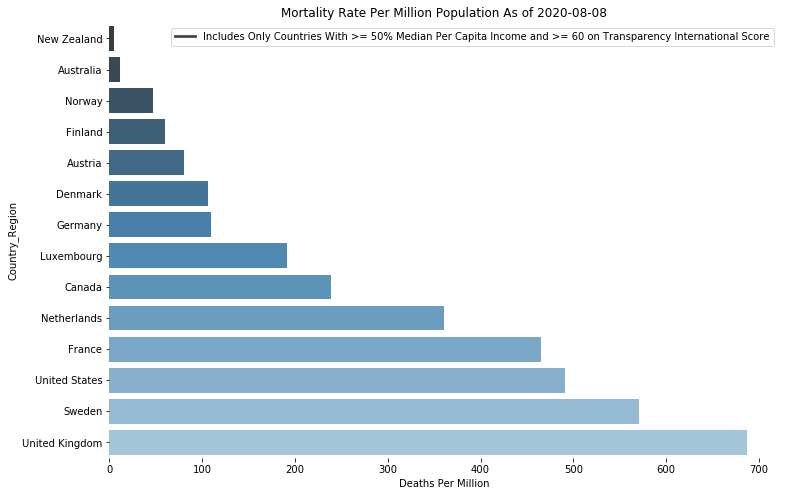

In [61]:
sign = '>='
mortality_population(q1_df, sign)

How many unique Alpha_3 codes (Country Codes) do we have in this dataset?

In [62]:
q1_df['Alpha_3'].nunique()

14

<a id='a1'></a>
### Answer to Question 1

> The above graph shows who is performing the best and the worst on the covid-19 pandemic. The only countries included in this bar graph have a Transparency International score of >= 60 and a MedianPerCapita Income >= 50% of the worlds countries. Countries with the shortest bars are doing better. Remember this IS adjusted for population. So, the fact that New Zealand is right at the top is remarkable. We should be looking at Australia and New Zealand to understand how they achieved this. 

> The USA is in the bottom third and the UK is at the very bottom. Perhaps a wake up call for their populations? The universe of countries that I chose for this was severely restricted by having the above cutoffs. As a result I feel this is a honest evaluation of the facts.

> One sobering thought here is that there are 203 unique Alpha_3 codes in this dataset. That corresponds to 203 countries. We are only looking at 28 of them. This is because of the concern over the honesty of the data. In otherwords the challenge that we are looking at here is only the tip of the iceberg. NB There are 195 countries in the world https://www.thoughtco.com/number-of-countries-in-the-world-1433445. The John Hopkins data has odd Country_Regions such as Cruise Ships. 

> I also looked at only countries that are "poor" but "honest" below.

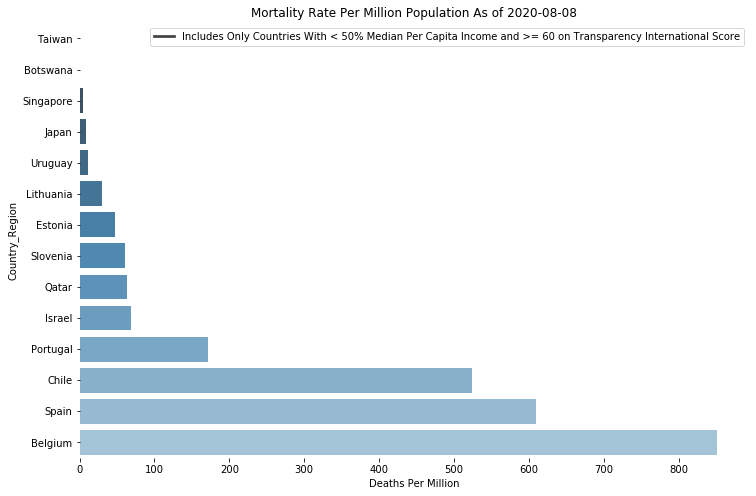

In [63]:
# Lets se how the other half lives:)
no_money_but_honest = q1_df_c[q1_df_c['TI_2019'] >= 60]
no_money_but_honest = no_money_but_honest[no_money_but_honest['MPC_Inc'] < q1_median_income]
no_money_but_honest.sort_values('Deaths_e6', inplace=True)

# Call the plotting function
sign = '<'
mortality_population(no_money_but_honest, sign)

In [64]:
print(no_money_but_honest['Country_Region'].tolist())

['Taiwan', 'Botswana', 'Singapore', 'Japan', 'Uruguay', 'Lithuania', 'Estonia', 'Slovenia', 'Qatar', 'Israel', 'Portugal', 'Chile', 'Spain', 'Belgium']


Taiwan is an island and was very aware of the dangers due to its intimate relationship with China. Botswana likely does not have the ability to count deaths. That sounds harsh but ... no national health system. People are probably just dying at home with no testing. Japan is highly sophisticated but ... it is surprising they are on this list as having a lower Median Per Capita Income. They just missed the cutoff. 

### Question 2

Which countries have flattened or are flattening the curve?

We will take our universe of countries from a set that is twice as large as Q1 above and see if they are experiencing a flattening of the curve. The metric will be the last 14 days with a regression line. If the regression line is flat or going down, they are flattening the curve. 

In [65]:
# groupby that creates a sum for each date for each country (Alpha_3).
q2_df = covid_pop_inc_df.groupby(['Date_','Alpha_3'], as_index=False)['Confirmed', 'Deaths'].sum()
q2_df.head()

C:\Users\linds\Anaconda3\envs\sklearn\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Date_ Alpha_3  Confirmed  Deaths
0 2020-01-22     CHN      547.0    17.0
1 2020-01-22     HKG        0.0     0.0
2 2020-01-22     JPN        2.0     0.0
3 2020-01-22     KOR        1.0     0.0
4 2020-01-22     MAC        1.0     0.0

In [66]:
# Now we want to merge the population and median income data with this.
q2_df = q2_df.merge(pop_inc_cc_codes)
print(q2_df.shape)
q2_df.head(1)

(19960, 8)


Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc     Pop2020  \
0 2020-01-22     CHN      547.0    17.0          China     1786  1439323775   

   TI_2019  
0       41

In [67]:
# Need to add the column New_Cases
# Calculate # of New_Cases/day
q2_df['New_Cases'] = q2_df['Confirmed'] - q2_df['Confirmed'].shift(1) 
print(q2_df.shape)
q2_df.tail(5)

(19960, 9)


Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc  Pop2020  \
19955 2020-08-04     TJK     7583.0    61.0     Tajikistan      713  9537645   
19956 2020-08-05     TJK     7625.0    61.0     Tajikistan      713  9537645   
19957 2020-08-06     TJK     7665.0    62.0     Tajikistan      713  9537645   
19958 2020-08-07     TJK     7706.0    62.0     Tajikistan      713  9537645   
19959 2020-08-08     TJK     7706.0    62.0     Tajikistan      713  9537645   

       TI_2019  New_Cases  
19955       25       45.0  
19956       25       42.0  
19957       25       40.0  
19958       25       41.0  
19959       25        0.0

In [68]:
q2_df.describe()

Confirmed         Deaths       MPC_Inc       Pop2020       TI_2019  \
count  1.996000e+04   19960.000000  19960.000000  1.996000e+04  19960.000000   
mean   5.099806e+04    2540.342134   4290.117435  6.472016e+07     45.639178   
std    2.435163e+05   10916.623690   4990.538460  1.987319e+08     19.442951   
min    0.000000e+00       0.000000     47.000000  4.415430e+05     13.000000   
25%    2.870000e+02       4.000000    627.000000  6.486205e+06     30.000000   
50%    2.026000e+03      50.500000   2011.000000  1.671896e+07     41.000000   
75%    1.788150e+04     474.000000   5519.000000  4.519577e+07     60.000000   
max    4.997929e+06  162423.000000  19308.000000  1.439324e+09     87.000000   

          New_Cases  
count  1.995900e+04  
mean   3.586853e-01  
std    4.584388e+04  
min   -4.997929e+06  
25%    3.000000e+00  
50%    3.800000e+01  
75%    3.395000e+02  
max    9.880700e+04

In [69]:
# Whoops there are some outliers here.
q2_df[q2_df['New_Cases'] < 0]

Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc  \
133   2020-06-03     CHN    84160.0  4638.0          China     1786   
200   2020-01-22     HKG        0.0     0.0      Hong Kong     9705   
296   2020-03-10     HKG      120.0     3.0      Hong Kong     9705   
298   2020-01-22     JPN        2.0     0.0          Japan    10840   
299   2020-01-23     JPN        1.0     0.0          Japan    10840   
...          ...     ...        ...     ...            ...      ...   
19375 2020-03-31     BDI        2.0     0.0        Burundi      129   
19506 2020-03-31     SLE        1.0     0.0   Sierra Leone      233   
19637 2020-04-10     YEM        1.0     0.0          Yemen      400   
19758 2020-04-30     COM        1.0     0.0        Comoros      598   
19859 2020-04-30     TJK       15.0     0.0     Tajikistan      713   

          Pop2020  TI_2019  New_Cases  
133    1439323775       41       -1.0  
200       7496981       76   -88672.0  
296       7496981       76     -110.0  
298     126476461       73     -118.0  
299     126476461       73       -1.0  
...           ...      ...        ...  
19375    11890784       19     -802.0  
19506     7976983       33     -404.0  
19637    29825964       15    -1894.0  
19758      869601       25    -1796.0  
19859     9537645       25     -384.0  

[164 rows x 9 columns]

In [70]:
# 0 out the offending values. We are just looking for a regression line here.
# That is probably the least harmful cleaning alternative.
q2_df['New_Cases'] = q2_df['New_Cases'].apply(lambda x: 0 if x < 0 else x)
q2_df.describe()

Confirmed         Deaths       MPC_Inc       Pop2020       TI_2019  \
count  1.996000e+04   19960.000000  19960.000000  1.996000e+04  19960.000000   
mean   5.099806e+04    2540.342134   4290.117435  6.472016e+07     45.639178   
std    2.435163e+05   10916.623690   4990.538460  1.987319e+08     19.442951   
min    0.000000e+00       0.000000     47.000000  4.415430e+05     13.000000   
25%    2.870000e+02       4.000000    627.000000  6.486205e+06     30.000000   
50%    2.026000e+03      50.500000   2011.000000  1.671896e+07     41.000000   
75%    1.788150e+04     474.000000   5519.000000  4.519577e+07     60.000000   
max    4.997929e+06  162423.000000  19308.000000  1.439324e+09     87.000000   

          New_Cases  
count  19959.000000  
mean     958.893031  
std     4640.057925  
min        0.000000  
25%        3.000000  
50%       38.000000  
75%      339.500000  
max    98807.000000

In [71]:
# Now convert New_Casess to a rate per million population
q2_df['New_Cases_e6'] = q2_df['Confirmed'] / (q2_df['Pop2020'] / 1000000)
q2_df.head(1)

Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc     Pop2020  \
0 2020-01-22     CHN      547.0    17.0          China     1786  1439323775   

   TI_2019  New_Cases  New_Cases_e6  
0       41        NaN       0.38004

In [72]:
q2_df.sort_values(['Date_', 'Alpha_3'], ignore_index=True, inplace=True)
print(q2_df.shape)
q2_df.tail()

(19960, 10)


Date_ Alpha_3  Confirmed    Deaths Country_Region  MPC_Inc  \
19955 2020-08-08     USA  4997929.0  162423.0  United States    15480   
19956 2020-08-08     VNM      812.0      10.0        Vietnam     1124   
19957 2020-08-08     YEM     1797.0     512.0          Yemen      400   
19958 2020-08-08     ZAF   553188.0   10210.0   South Africa     1217   
19959 2020-08-08     ZMB     7903.0     203.0         Zambia      287   

         Pop2020  TI_2019  New_Cases  New_Cases_e6  
19955  331002651       69    56174.0  15099.362452  
19956   97338579       37       23.0      8.342016  
19957   29825964       15        1.0     60.249520  
19958   59308690       44     7712.0   9327.267218  
19959   18383955       34      417.0    429.885735

In [73]:
# This is the df that we need for q4. Lets make a copy of it.
q4_df = q2_df.copy(deep=True)

In [74]:
# Need the date of the last row in the df
end = q2_df.iloc[-1,0]
end

Timestamp('2020-08-08 00:00:00')

In [75]:
# We want the date x days ago
days = 14
start = end - timedelta(days=days)
start

Timestamp('2020-07-25 00:00:00')

In [76]:
q2_df = q2_df[q2_df['Date_'] >= start]
q2_df.shape

(1830, 10)

We do not think the reporting is correct. We are restricting our analysis to countries that have a Transparency International rating >= 60. The USA has a rating of 69. 

In [77]:
q2_df = q2_df[q2_df['TI_2019'] >= 60]
print(q2_df.shape)
q2_df.head()

(420, 10)


Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc   Pop2020  \
18135 2020-07-25     AUS    14403.0   155.0      Australia    15026  25499884   
18136 2020-07-25     AUT    20338.0   712.0        Austria    12284   9006398   
18139 2020-07-25     BEL    65727.0  9821.0        Belgium    10189  11589623   
18148 2020-07-25     BWA      686.0     1.0       Botswana      740   2351627   
18149 2020-07-25     CAN   115470.0  8929.0         Canada    15181  37742154   

       TI_2019  New_Cases  New_Cases_e6  
18135       77      453.0    564.826099  
18136       77      124.0   2258.172468  
18139       75      528.0   5671.193964  
18148       61        0.0    291.712929  
18149       77      355.0   3059.443825

In [78]:
# Get a list with no duplicates from Country_Region
countries = q2_df['Country_Region'].tolist()
countries = (set(countries))
countries = list(countries)
countries.sort()
print(len(countries))
print(countries)

28
['Australia', 'Austria', 'Belgium', 'Botswana', 'Canada', 'Chile', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Israel', 'Japan', 'Lithuania', 'Luxembourg', 'Netherlands', 'New Zealand', 'Norway', 'Portugal', 'Qatar', 'Singapore', 'Slovenia', 'Spain', 'Sweden', 'Taiwan', 'United Kingdom', 'United States', 'Uruguay']


In [79]:
# Did not run this one because the output was too small to be of use. 
# I include it here because if I was reviewing this I would ask why I did not use FacetGrid.

# g = sns.FacetGrid(q2_df, col="Country_Region", col_wrap=4, height=2)
# g.map(sns.pointplot, 'Date_String', 'New_Cases', order=date_string, color=".3", ci=None);

We run the below regression plot in full size. In small size (above), you lose the details of whether or not the # of New_Cases is trending up or down.

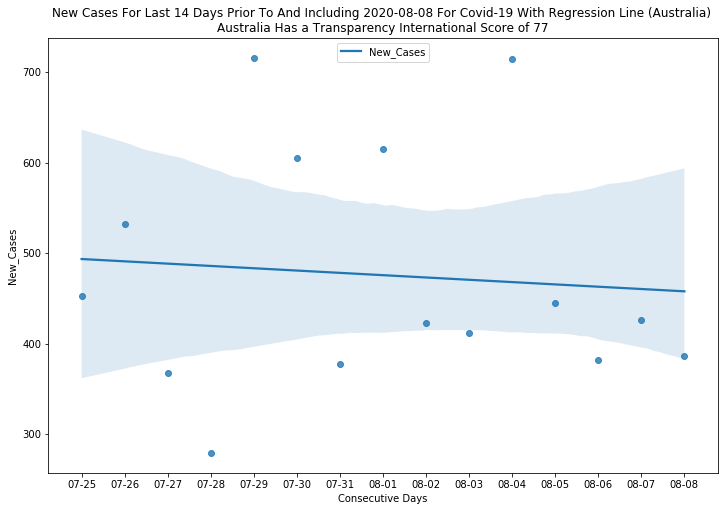

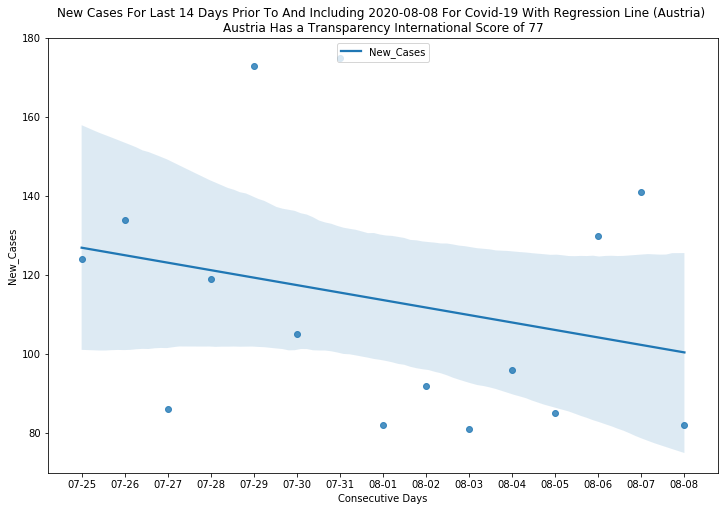

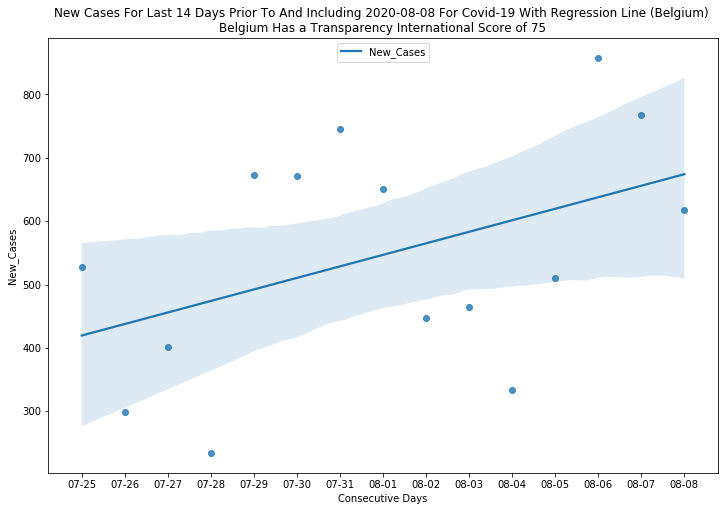

C:\Users\linds\Anaconda3\envs\sklearn\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


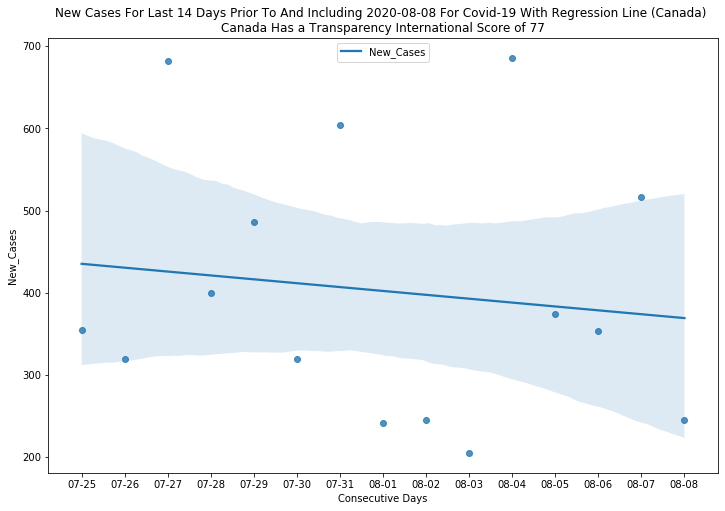

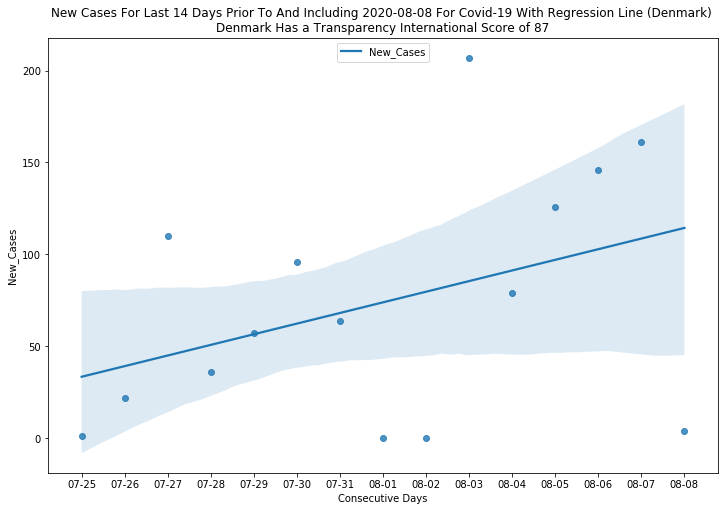

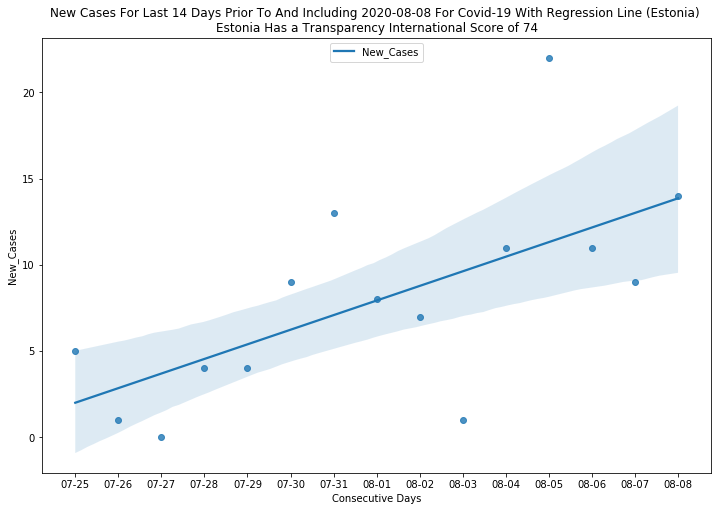

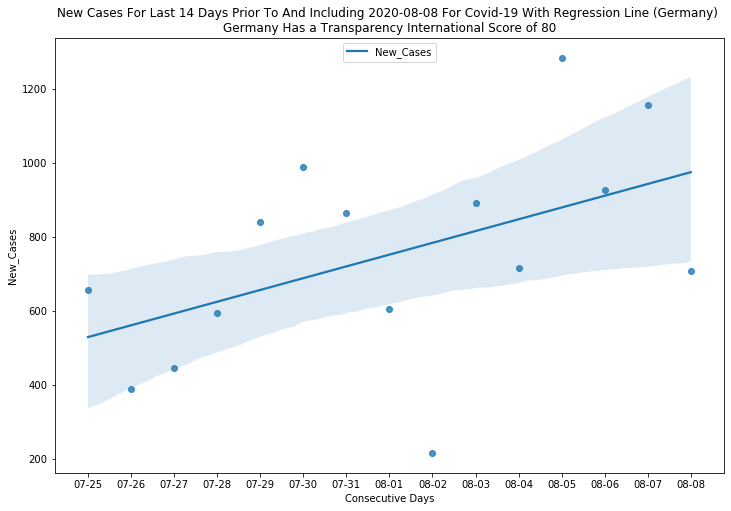

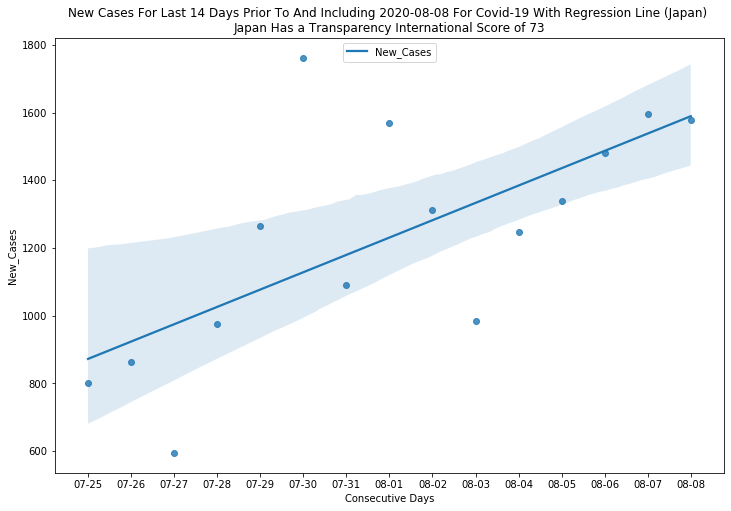

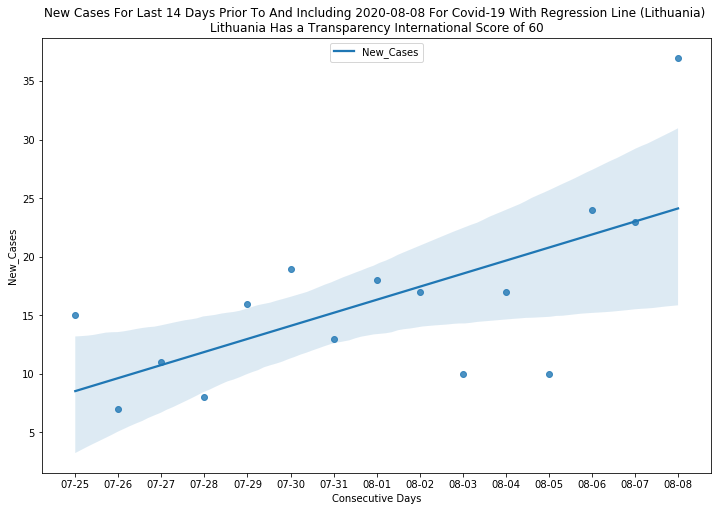

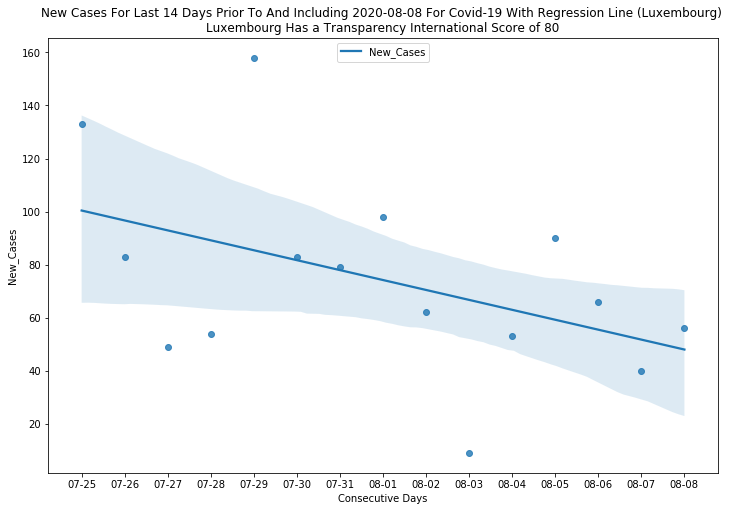

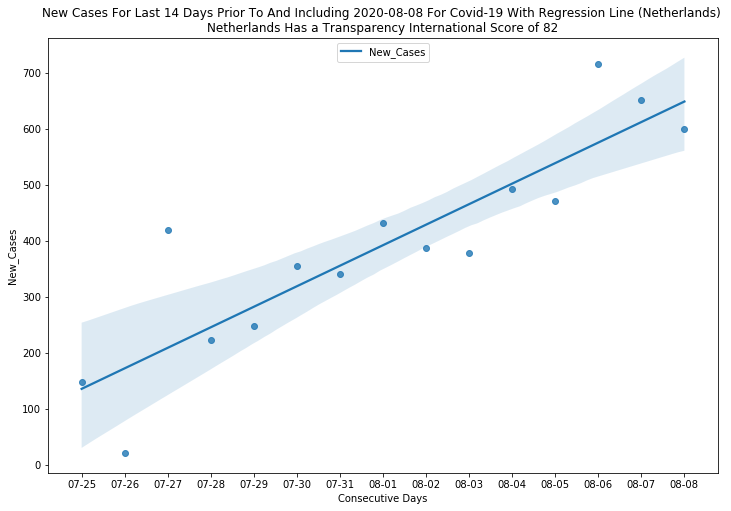

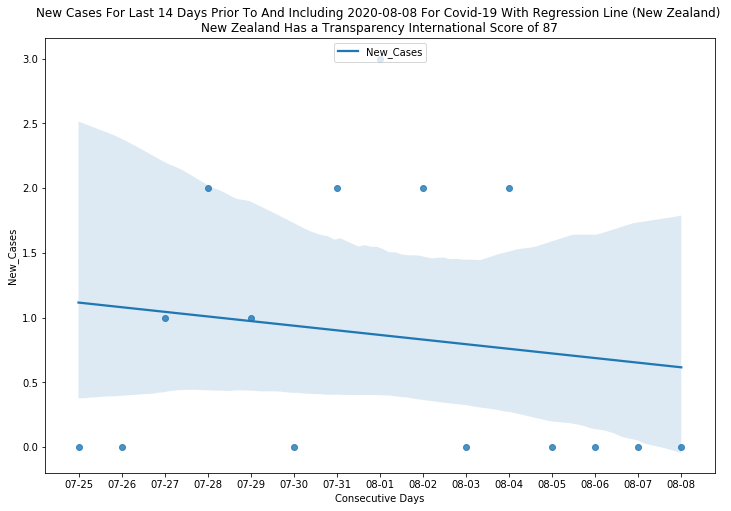

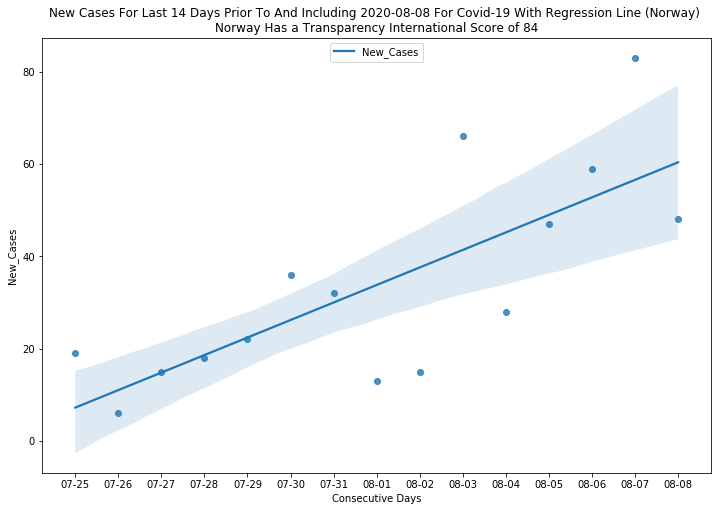

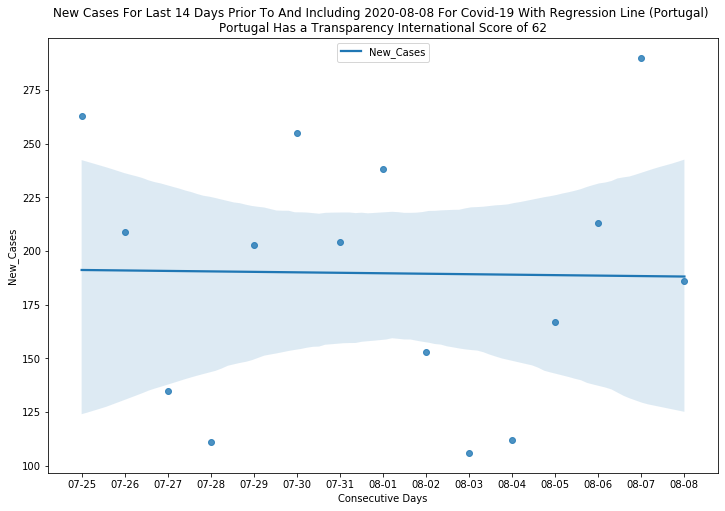

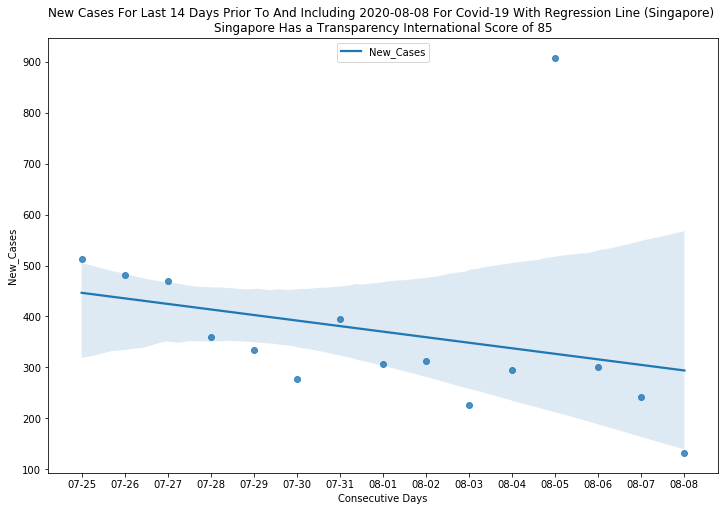

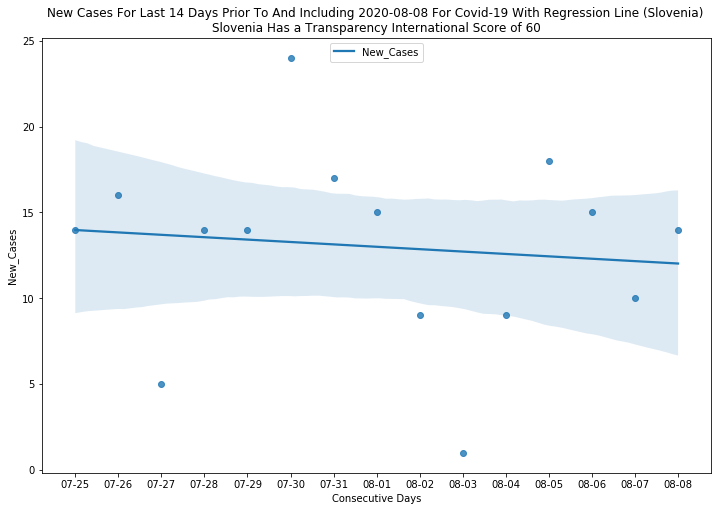

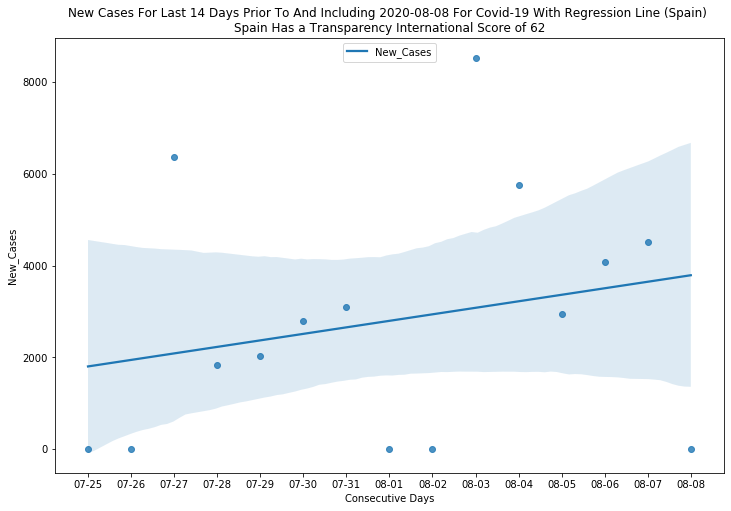

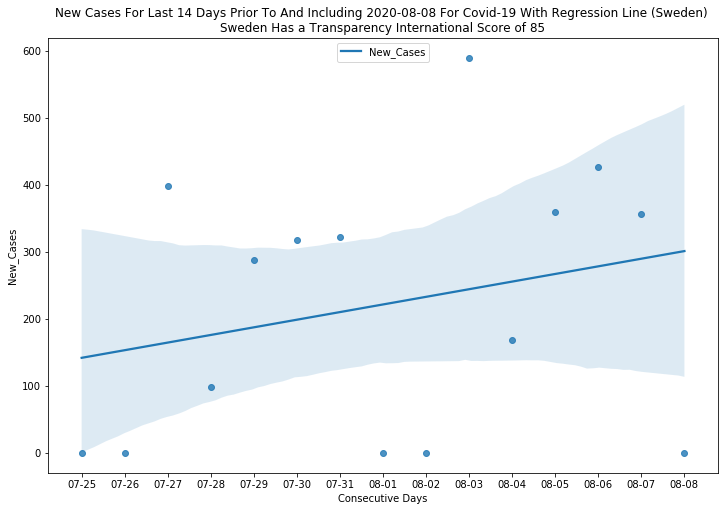

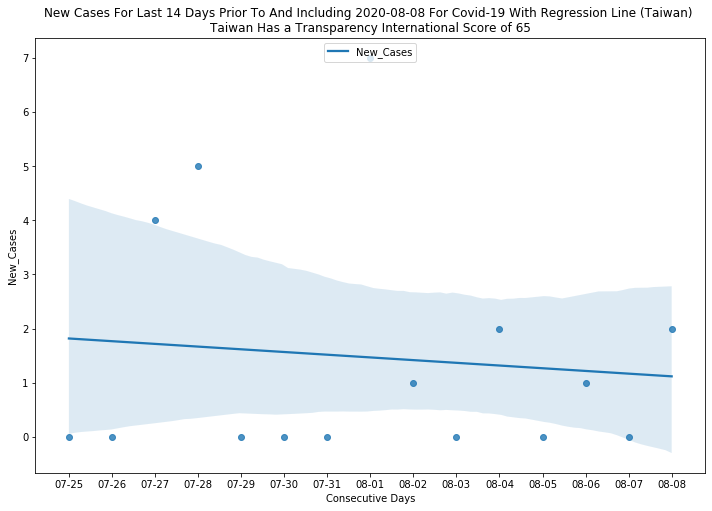

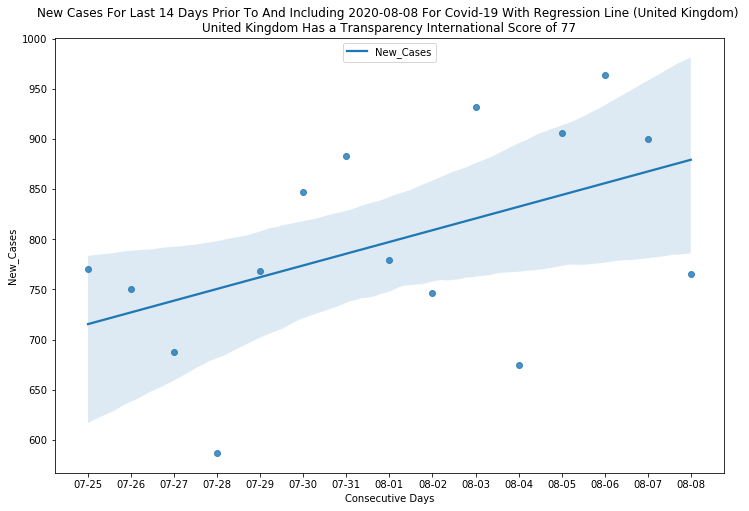

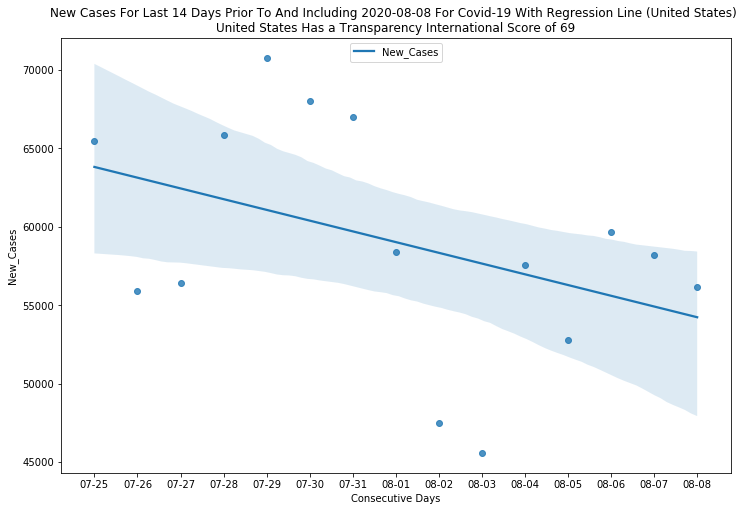

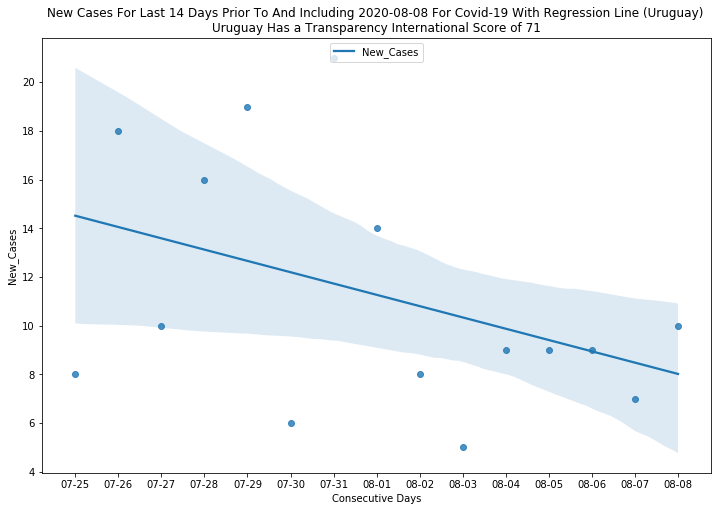

In [80]:
# Run regression line plot of ONLY countries that ARE NOT flattening the curve
flat = []
rising = []
falling = []

for country in countries:

    # Just the country of interest
    recent = q2_df[q2_df['Country_Region'] == country]
    
    # Check and see if it is falling, flat, or rising

    # Find half way
    first_half = float(len(recent))
    first_half = int(first_half / 2)

    # first half mean
    first_half_mean = recent['New_Cases'].iloc[:first_half].mean()

    # second half mean
    second_half_mean = recent['New_Cases'].iloc[first_half:].mean()
    
    # slant
    slant = first_half_mean / second_half_mean

    # Check for flat           
    if  .9 < slant < 1.1:
        flat.append(country)
        
    # Check for falling
    elif first_half_mean > second_half_mean:
        falling.append(country)
        
    # Else rising
    else:
        rising.append(country)
        
    # Plot
    regression_new_cases(recent, country, days)

In [81]:
print('flat\n', sorted(flat))
print('\nfalling \n', sorted(falling))
print('\nrising \n', sorted(rising))

flat
 ['Australia', 'Chile', 'New Zealand', 'Portugal', 'United Kingdom']

falling 
 ['Austria', 'Botswana', 'Canada', 'Israel', 'Luxembourg', 'Qatar', 'Singapore', 'Slovenia', 'United States', 'Uruguay']

rising 
 ['Belgium', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Japan', 'Lithuania', 'Netherlands', 'Norway', 'Spain', 'Sweden', 'Taiwan']


<a id='a2'></a>
### Answer to Question 2

> The above graphs show you the flat, rising, and falling regression lines for each country. NB some times the crude calculation that I make in the code is not as capable at recognizing the trend as the human eye. The flat list contains the countries that have daily flat numbers of New_Cases of covid-19. The falling list are those countries that have lower numbers of New_Cases over the 14 day period. The rising list are the countries where increased trouble is very close at hand. However, much better than I thought!  

> We do not cutoff based on Median Per Capita Income on this list. The only cutoff is the Transparency International score. That is why we have ~ twice as many countries being considered.

### Question 3

Can I see a global geographic representation of infections?

Yes, however, we are only going to do this for the last date that we have data on. The John Hopkins dashboard at https://coronavirus.jhu.edu/map.html is an impressive interactive facility that has the ability to visualize data geographically at a much greater level of sophistication than what I will be doing here. The purpose here was to append demographic information (population and Median Per Capita Income) and a "honesty score" via the Transparency International score so that we cam gain some confidence about the usefulness of this data. 

In [82]:
# Identify shape file
shapefile = r'data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'

#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

country country_code  \
0                         Fiji          FJI   
1  United Republic of Tanzania          TZA   
2               Western Sahara          SAH   
3                       Canada          CAN   
4     United States of America          USA   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

We can drop the row for ‘Antarctica’ as it unnecessarily occupies a large space in our map and is not required in our current analysis.

In [83]:
gdf[gdf['country'] == 'Antarctica']

country country_code  \
159  Antarctica          ATA   

                                              geometry  
159  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...

In [84]:
#Drop row corresponding to 'Antarctica'
gdf = gdf.drop(gdf.index[159])

In [85]:
# groupby that creates a sum for each date for each country (Alpha_3).
q3_df = covid_pop_inc_df.groupby(['Date_','Alpha_3'], as_index=False)['Confirmed', 'Deaths'].sum()
q3_df.head()

C:\Users\linds\Anaconda3\envs\sklearn\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Date_ Alpha_3  Confirmed  Deaths
0 2020-01-22     CHN      547.0    17.0
1 2020-01-22     HKG        0.0     0.0
2 2020-01-22     JPN        2.0     0.0
3 2020-01-22     KOR        1.0     0.0
4 2020-01-22     MAC        1.0     0.0

In [86]:
# Now we want to merge the population and median income data with this.
q3_df = q3_df.merge(pop_inc_cc_codes)
print(q3_df.shape)
q3_df.head(1)

(19960, 8)


Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc     Pop2020  \
0 2020-01-22     CHN      547.0    17.0          China     1786  1439323775   

   TI_2019  
0       41

In [87]:
# Restrict the analysis to just the most recent date for data
q3_df = q3_df[q3_df['Date_'] == end]
print(q3_df.shape)
q3_df.tail(1)

(122, 8)


Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc  Pop2020  \
19959 2020-08-08     TJK     7706.0    62.0     Tajikistan      713  9537645   

       TI_2019  
19959       25

In [88]:
q3_df.describe()

Confirmed         Deaths       MPC_Inc       Pop2020     TI_2019
count  1.220000e+02     122.000000    122.000000  1.220000e+02  122.000000
mean   1.562742e+05    5849.713115   3981.016393  5.843516e+07   44.409836
std    5.641937e+05   19069.497841   4848.304543  1.836940e+08   19.193988
min    2.680000e+02       0.000000     47.000000  4.415430e+05   13.000000
25%    2.235000e+03      68.250000    617.750000  6.009308e+06   29.250000
50%    2.053100e+04     406.500000   1790.500000  1.468904e+07   40.000000
75%    8.212575e+04    2206.000000   5162.000000  4.382039e+07   57.500000
max    4.997929e+06  162423.000000  19308.000000  1.439324e+09   87.000000

In [89]:
q3_df.isnull().mean()

Date_             0.0
Alpha_3           0.0
Confirmed         0.0
Deaths            0.0
Country_Region    0.0
MPC_Inc           0.0
Pop2020           0.0
TI_2019           0.0
dtype: float64

Above looks fine.

In [90]:
# Change Date to string date. Bokey does not like real dates (sigh)
q3_df['Date_'] = end.strftime('%Y-%m-%d')
q3_df.head(1)

Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc  \
199  2020-08-08     CHN    88672.0  4681.0          China     1786   

        Pop2020  TI_2019  
199  1439323775       41

In [91]:
# Add column for Deaths Per Million
q3_df['Deaths_e6'] = q3_df['Deaths'] / (q3_df['Pop2020'] / 1000000)

Need to normalize the data.

In [92]:
# Get object column names
cat_cols = q3_df.select_dtypes('object').columns
cat_cols

Index(['Date_', 'Alpha_3', 'Country_Region'], dtype='object')

In [93]:
# Keep only the categorical columns
cat_cols_df = q3_df[cat_cols]
cat_cols_df.reset_index(drop=True, inplace=True)
print(cat_cols_df.shape)
cat_cols_df.head(1)

(122, 3)


Date_ Alpha_3 Country_Region
0  2020-08-08     CHN          China

In [94]:
# Get numeric column names
num_cols = q3_df.select_dtypes([np.number]).columns
num_cols

Index(['Confirmed', 'Deaths', 'MPC_Inc', 'Pop2020', 'TI_2019', 'Deaths_e6'], dtype='object')

In [95]:
# numpy array of just the numeric values
x = q3_df[num_cols].values
x.shape

(122, 6)

In [96]:
# normalize the data
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

In [97]:
# Now a numeric df
num_cols_df = pd.DataFrame(x_scaled, columns=num_cols)
print(num_cols_df.shape)
num_cols_df.head(1)

(122, 6)


Confirmed   Deaths   MPC_Inc  Pop2020   TI_2019  Deaths_e6
0   0.017689  0.02882  0.090286      1.0  0.378378   0.003819

In [98]:
# Concatenate the two dataframes.
new_df = pd.concat([cat_cols_df, num_cols_df], axis=1)
print(new_df.shape)
new_df.head(1)

(122, 9)


Date_ Alpha_3 Country_Region  Confirmed   Deaths   MPC_Inc  Pop2020  \
0  2020-08-08     CHN          China   0.017689  0.02882  0.090286      1.0   

    TI_2019  Deaths_e6  
0  0.378378   0.003819

In [99]:
new_df.isnull().mean()

Date_             0.0
Alpha_3           0.0
Country_Region    0.0
Confirmed         0.0
Deaths            0.0
MPC_Inc           0.0
Pop2020           0.0
TI_2019           0.0
Deaths_e6         0.0
dtype: float64

In [100]:
new_df.describe()

Confirmed      Deaths     MPC_Inc     Pop2020     TI_2019   Deaths_e6
count  122.000000  122.000000  122.000000  122.000000  122.000000  122.000000
mean     0.031216    0.036015    0.204248    0.040305    0.424457    0.124398
std      0.112892    0.117406    0.251716    0.127664    0.259378    0.200366
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.000394    0.000420    0.029632    0.003870    0.219595    0.007147
50%      0.004054    0.002503    0.090520    0.009902    0.364865    0.039612
75%      0.016379    0.013582    0.265563    0.030148    0.601351    0.123637
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000

Above all looks good!

In [101]:
# Merge dataframes with left join. Avoids missing countries.
merged = gdf.merge(new_df, left_on = 'country_code', right_on = 'Alpha_3', how='left')

# Replace NaN values to string 'No data'. This is caused by the left join (obviously)
merged.fillna('No data', inplace = True)

print(merged.shape)
merged.head(5)

(177, 12)


country country_code  \
0                         Fiji          FJI   
1  United Republic of Tanzania          TZA   
2               Western Sahara          SAH   
3                       Canada          CAN   
4     United States of America          USA   

                                            geometry       Date_  Alpha_3  \
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...     No data  No data   
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  2020-08-08      TZA   
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...     No data  No data   
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  2020-08-08      CAN   
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  2020-08-08      USA   

  Country_Region    Confirmed       Deaths    MPC_Inc    Pop2020   TI_2019  \
0        No data      No data      No data    No data    No data   No data   
1       Tanzania  4.82226e-05  0.000129292  0.0174965  0.0412075  0.324324   
2        No data      No data      No data    No data    No data   No data   
3         Canada    0.0241873    0.0555586   0.785733  0.0259233  0.864865   
4  United States            1            1   0.801256   0.229735  0.756757   

     Deaths_e6  
0      No data  
1  0.000412808  
2      No data  
3     0.280753  
4     0.576193

In [102]:
q3_df.head(1)

Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc  \
199  2020-08-08     CHN    88672.0  4681.0          China     1786   

        Pop2020  TI_2019  Deaths_e6  
199  1439323775       41   3.252222

In [103]:
# Instantiate a dictionary with the numeric feature columns
feature_dict = dict(zip(num_cols, range(len(num_cols))))
feature_dict

{'Confirmed': 0,
 'Deaths': 1,
 'MPC_Inc': 2,
 'Pop2020': 3,
 'TI_2019': 4,
 'Deaths_e6': 5}

In [104]:
# Now that we have this in a function, lets run all of the numeric columns thru this.
# Create a dictionary with the appropriate strings
feature_dict.update({num_cols[0]: ['Confirmed', 'Fewest Cases', 'Covid-19 Confirmed Cases By Country'],
                    num_cols[1]: ['Deaths', 'Fewest Deaths', 'Covid-19 Deaths By Country'],
                    num_cols[2]: ['MPC_Inc', 'Lowest', 'Median Per Capita Income By Country'],
                    num_cols[3]: ['Pop2020', 'Lowest', 'Population By Country'],
                    num_cols[4]: ['TI_2019', 'Least Honest', 'Transparency International Score By Country'],
                    num_cols[5]: ['Deaths_e6', 'Fewest Deaths', 'Covid-19 Deaths By Country Per Million Population']
                   })

In [105]:
# Prepare map for all features
for feature in num_cols:
    plot_world_map(merged, feature_dict[feature])

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

<a id='a3'></a>
### Answer to Question 3

> The above images quickly tell you where the challenges are. Any country that shows color on the 'Covid-19 Deaths By Country Adjusted For Population' map is in trouble. The grey countries are not reporting data. If you look at the 'Transparency International Score By Country' (right above that one), you can immediately see the issue about reporting. Countries that are honest are reporting and as a result report higher deaths. The vast majority of countries are either not reporting or are "not honest". 

<a id='model'></a>
## Model Data


### Question 4

What is the projected global mortality by December 31, 2020?

The way we are going to answer this is to look at a correlation heat map. That will instruct as to what variable would be helpful in terms of predicting deaths. Then we are simply going to do a simple regression line and extend it using trigonometry. Finally I will run an ARMIM model that predicts every day going forward to the end of 2020.

In [106]:
# Look at df just to remind me of what I have.
q4_df.head(1)

Date_ Alpha_3  Confirmed  Deaths Country_Region  MPC_Inc     Pop2020  \
0 2020-01-22     CHN      547.0    17.0          China     1786  1439323775   

   TI_2019  New_Cases  New_Cases_e6  
0       41        NaN       0.38004

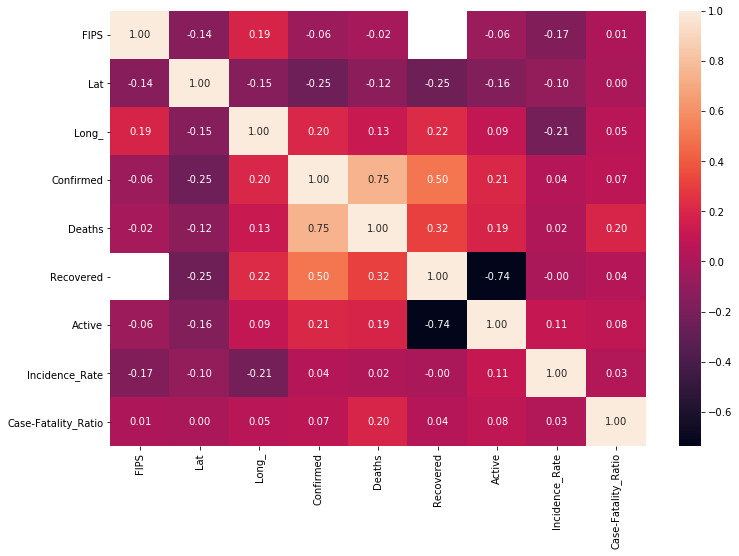

In [107]:
# Look at the correlations. Should be pretty good.
sns.heatmap(df.corr(), annot=True, fmt=".2f");

The correlation is very high between Confirmed and Deaths. You can see New_Cases_e6 is also correlated (.54) with deaths. There are obvious cases of multicollinearity in the features that are in this dataset (Confirmed, New_Cases, New_Cases_e6). There is considerable uncertainty about the quality of the data that is being reported. We  want to predict to the end of 2020 what will be the total number of global deaths. If we have a regression line we can do that quite simply using trigonometry. Lets do that below.

We simply do not need all of the complexity of the q4_df dataset to answer this question. The global_df that we created earlier in the notebook works quite well for this. It is created via a groupby on Date_ with a sum. This yields the following very simple dataset after dropping a few columns. Remember though, for Confirmed and for Deaths the numbers are cumulative. Mortality_Rate is a simple division based on the previous 2 columns.

In [108]:
print(global_df.shape)
global_df.tail(1)

(190, 3)


Confirmed    Deaths  Mortality_Rate
Date_                                           
2020-08-08  19637506.0  726781.0         0.03701

#### Trigonometry
 
 We are going to find the angle (bottom left hand side) then calculate the Opposite. The Adjacent is the difference in days between Feb 1 2020 and Dec 31 2020. In order to get the initial angle we are using the above regression line and creating a right triangle to work from. 

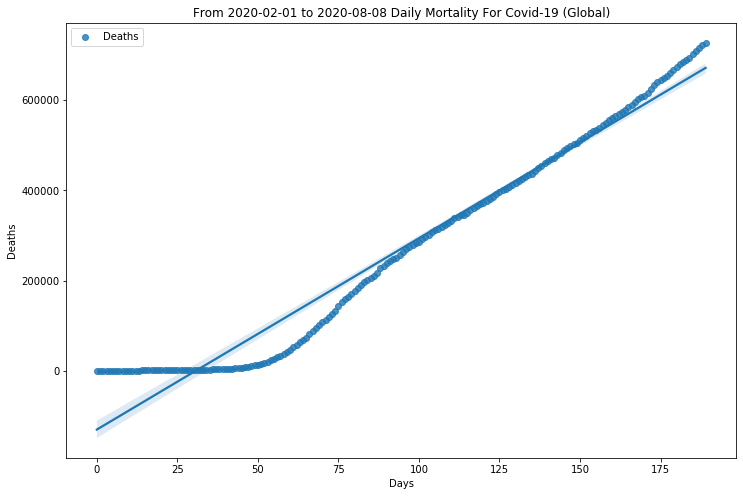

In [109]:
regression_deaths(global_df, 'Global')

In [110]:
# Estimate the total number of deaths by the end of the year

# Find the angle based on the above regression line.
angle = calc_angle(global_df, 270000)

# Time period
start = '2020-02-01'
end = '2020-12-31'

# Estimate year end deaths
deaths, days = calc_deaths(angle, start, end)
print(f'The number of expected deaths forecast to occcur from Covid-19 by {end} is: {place_value(deaths)}.')
print(f'This is over the next {days} days.')

The number of expected deaths forecast to occcur from Covid-19 by 2020-12-31 is: 477,142.
This is over the next 334 days.


#### ARIMA Model

I have a number of features that we could use to predict mortality. However, the obvious one is to simply use Death. This machine learning algorithm is well suited to univariate time series. 

Lets see what is going to happen to the USA.

Create and summarize a stationary version of the time series. 

In [111]:
# create a differenced series
def difference(dataset):
    """Create a difference between first value and the second value in the input"""
    
    diff = []
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)

    return pd.Series(diff)

In [112]:
# Load the data 
series = global_df['Deaths']
series.head()

Date_
2020-02-01    259.0
2020-02-02    362.0
2020-02-03    426.0
2020-02-04    492.0
2020-02-05    564.0
Name: Deaths, dtype: float64

In [113]:
# Convert it to an array
X = series.values
X = X.astype('float32') 

In [114]:
# difference data
stationary = difference(X)
stationary.index = series.index[1:]

In [115]:
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.775521
p-value: 0.392681
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


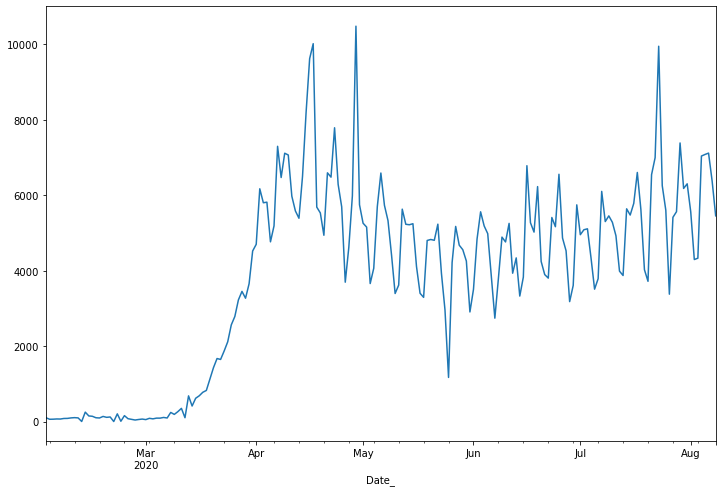

In [116]:
# plot differenced data
stationary.plot()
plt.show();

That is not stationary!. That is not good. We can get the ARIMA model to grid search a solution to this.

In [117]:
# save
stationary.to_csv(r'data/stationary.csv')

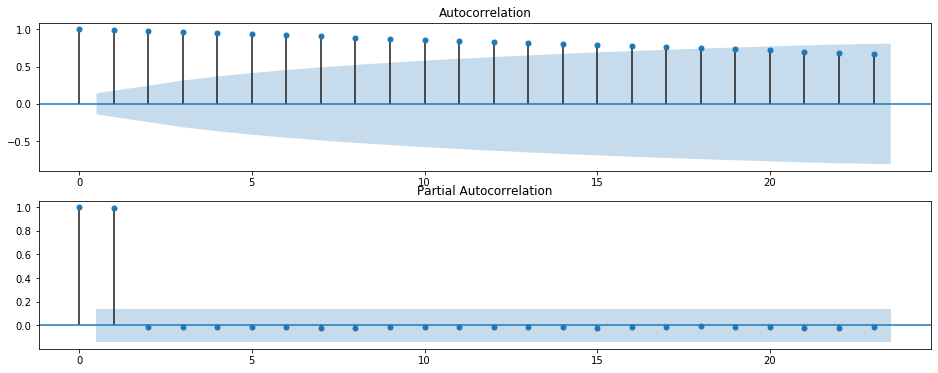

In [118]:
# ACF and PACF plots of the time series
series = global_df['Deaths']
plt.figure(figsize=(16,6))
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

- The ACF shows significant lags to 10 time steps.
- The PACF shows significant lags to 2 time step.

This quick analysis suggests an ARIMA(10,2,1) on the raw data may be a good starting point. I ran it. It did not converge. So, lets evaluate a series of ARIMA models with a try and except block to avoid "LinAlgError: SVD did not converge"

In [119]:
# grid search ARIMA parameters

def evaluate_arima_model(X, arima_order):
    """evaluate an ARIMA model for a given order (p,d,q) and return RMSE"""    
    
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        
        # fit model
        try:
            model_fit = model.fit(trend='nc', disp=0)
            yhat = model_fit.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        except:
            continue
        
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [120]:
def evaluate_models(dataset, p_values, d_values, q_values):
    """evaluate combinations of p, d and q values for an ARIMA model"""    
    
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
                   
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
    return best_cfg

In [136]:
# load dataset
series = global_df['Deaths']

# evaluate parameters
p_values = range(2,6)
d_values = range(2,6)
q_values = range(2,6)
warnings.filterwarnings("ignore")
best_cfg = evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(2, 2, 2) RMSE=956.294
ARIMA(2, 2, 4) RMSE=871.484
ARIMA(3, 2, 2) RMSE=857.472
ARIMA(4, 2, 2) RMSE=848.424
Best ARIMA(4, 2, 2) RMSE=848.424


As we can see from the above, a LOT of these parameters resulted in the model not being able to fit it. 

                 0
count    95.000000
mean     24.932141
std     852.557059
min   -2118.951422
25%    -568.388903
50%     -79.611935
75%     579.942681
max    3141.399258


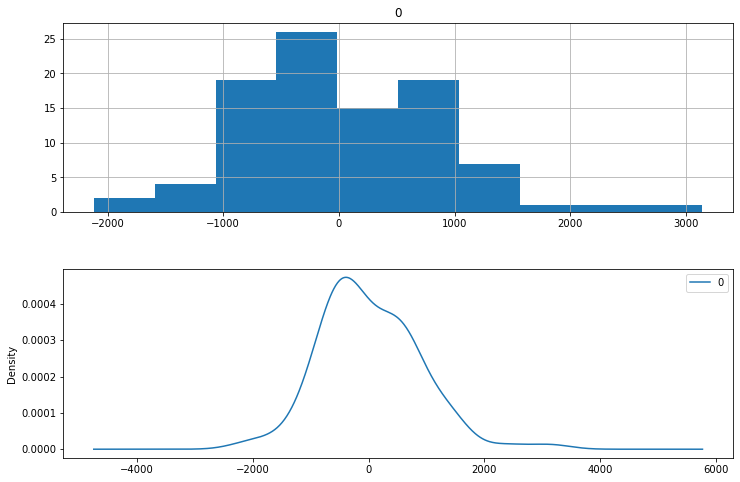


bias saved in bias for subsequent run is: 24.932141482876002 



In [137]:
# summarize residual errors for an ARIMA model

# load data
series = global_df['Deaths']

# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
    
    # predict
    model = ARIMA(history, order=best_cfg)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())

# plot
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show();

# Save mean for bias adjustment below
bias = residuals.describe()
bias = bias.iloc[1][0]
print('\nbias saved in bias for subsequent run is:', bias, '\n')

The histogram shows that the distribution has a right skew and that the mean is non-zero. This is perhaps a sign that the predictions are biased. The distribution of residual errors is also plotted. The graphs suggest a Gaussian-like distribution with a longer left tail. Lets see if the bias made any real difference.

RMSE: 848.058
       Residual Statistics
count         9.500000e+01
mean          1.041611e-11
std           8.525571e+02
min          -2.143884e+03
25%          -5.933210e+02
50%          -1.045441e+02
75%           5.550105e+02
max           3.116467e+03


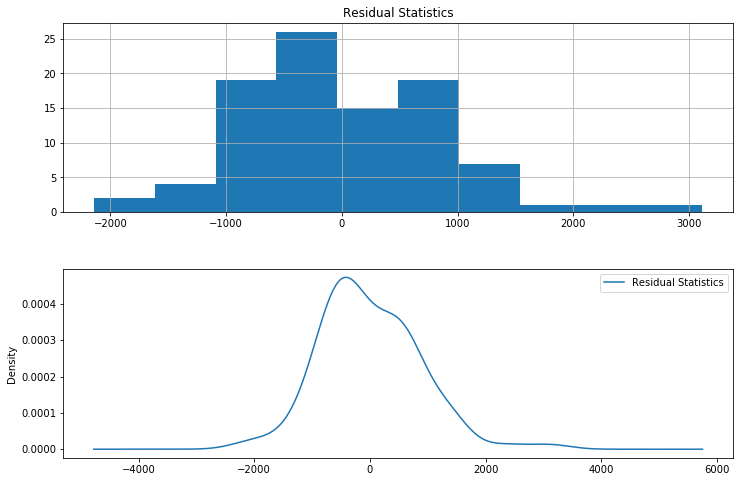

In [138]:
# summarize residual errors from bias corrected forecasts

# load data
series = global_df['Deaths']

# prepare data
X = series.values.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
bias = bias # from above run
for i in range(len(test)):
    
    # predict
    model = ARIMA(history, order=best_cfg)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# summarize residual errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
residuals = residuals.rename({0: 'Residual Statistics'}, axis=1)
print(residuals.describe())

# plot
# histogram
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())

# density
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

The bias had almost no effect on the RMSE. Considering that we will be looking at deaths in the range of 6 to 7 figures, not surprising that this made so little difference. 

The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero. Finally, density plots of the residual error do show a small shift towards zero. Lets take a look at test vs predictions.

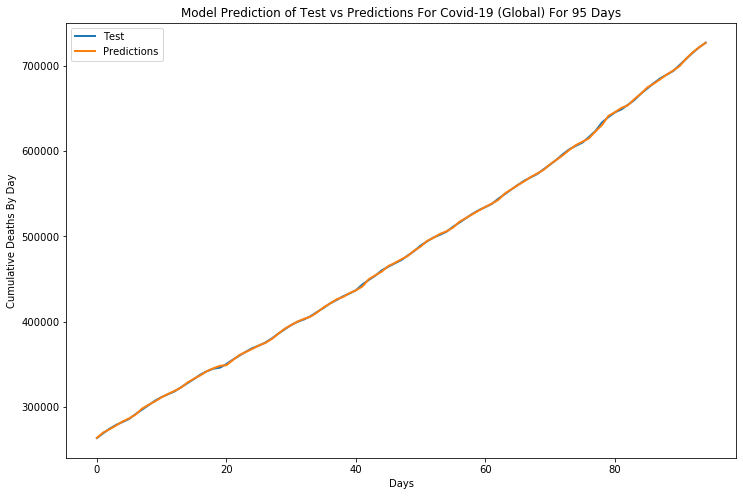

In [139]:
# Assemble title
title = ('Model Prediction of Test vs Predictions For Covid-19 ({}) For {} Days').format('Global', len(test))
plt.title(title)

# Create x and y axis labels
plt.xlabel('Days')
plt.ylabel('Cumulative Deaths By Day')

# Create plot
plt.plot(test, linewidth=2, label='Test')
plt.plot(predictions, linewidth=2, label='Predictions')
plt.legend()
plt.savefig(r'pics_final/test_vs_prediction.png');

Wow hard to believe that this is that accurate!

In [140]:
# save finalized model to file

def __getnewargs__(self):
    """# monkey patch around bug in ARIMA class"""
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# load data
series = global_df['Deaths']

# prepare data
X = series.values.astype('float32')

# fit model
model = ARIMA(X, order=best_cfg)
model_fit = model.fit(trend='nc', disp=0)

# bias constant, could be calculated from in-sample mean residual
bias = bias

# save model
model_fit.save(r'data/model.pkl')
np.save(r'data/model_bias.npy', [bias])

In [141]:
# load finalized model and make a prediction

# Load model
model_fit = ARIMAResults.load(r'data/model.pkl')
bias = np.load(r'data/model_bias.npy')

# Pick a future to predict. 0 means literally tomorrow.
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.0f' % yhat)

Predicted: 731526


This proves the model was saved,  loaded successfully, and performed a prediction. Lets forecast every day between now and December 31, 2020. We are also going to use ALL of the data since we have now put the model into "production".

In [142]:
global_df.shape

(190, 3)

In [143]:
# load dataset
series = global_df['Deaths']
X = series.values


# fit model
model = ARIMA(X, order=(best_cfg))
model_fit = model.fit(disp=0)

# forecast Dec 31 2020
start = global_df.index[-1]
end = pd.to_datetime('2021-01-01', infer_datetime_format=True)
steps = end - start
steps = steps.days

# Fit the out of sample
forecast = model_fit.forecast(steps=steps)[0]

# Add the bias
predictions = []
for yhat in forecast:

    yhat = bias[0] + yhat
    predictions.append(yhat)
    
# Create a df for reporting
# Create a date_range index
start = global_df.index[-1]
end = start + timedelta(days=steps-1)

# Create the df
forecast_df = pd.DataFrame({'Deaths': predictions}, index=pd.date_range(start=start, end=end))

# Shift Deaths by one day to make it line up correctly with the date. 
forecast_df['Deaths'] = forecast_df['Deaths'].shift(1)
forecast_df = forecast_df[1:]
forecast_df.tail(1)

Deaths
2020-12-31  1.946115e+06

That is a pretty big number. Lets check and see if it is reasonable. We will look at global_df and calculate its daily percent increase. Then we will look at forecast_df and see if it is comparable. 

In [144]:
# Take a copy of global_df
global_df_c = global_df.copy(deep=True)

# Drop the extra columns in global_df_c compared to report_df
global_df_c = global_df_c[['Deaths']]

# Create the extra columns
global_df_c['Increase'] = global_df_c['Deaths'] - global_df_c['Deaths'].shift(1)
global_df_c['Percent_Increase'] = (global_df_c['Increase'] / global_df_c['Deaths']) * 100
global_df_c['Percent_Increase'] = round(global_df_c['Percent_Increase'], 2)
global_df_c['Deaths'] = global_df_c['Deaths'].astype(np.int)

# Look at it
global_df_c.tail()

Deaths  Increase  Percent_Increase
Date_                                         
2020-08-04  700736    7042.0              1.00
2020-08-05  707820    7084.0              1.00
2020-08-06  714940    7120.0              1.00
2020-08-07  721324    6384.0              0.89
2020-08-08  726781    5457.0              0.75

In [145]:
# Look at daily percent increase for first 5 days
forecast_df['Increase'] = forecast_df['Deaths'] - forecast_df['Deaths'].shift(1)
forecast_df['Percent_Increase'] = (forecast_df['Increase'] / forecast_df['Deaths']) * 100
forecast_df['Percent_Increase'] = round(forecast_df['Percent_Increase'] ,2)
forecast_df['Deaths'] = forecast_df['Deaths'].astype(np.int)
forecast_df.head()

Deaths     Increase  Percent_Increase
2020-08-09  731603          NaN               NaN
2020-08-10  736844  5240.191800              0.71
2020-08-11  743165  6321.063440              0.85
2020-08-12  750428  7263.071000              0.97
2020-08-13  757836  7408.154058              0.98

In [146]:
print('These means all have to do with the day to day percentage increase.\n')
print(f'Last 14 days actual data mean is: {round(global_df_c.Percent_Increase.iloc[-14:].mean(), 2)}')
print(f'First 14 days forecast mean is: {round(forecast_df.Percent_Increase.iloc[:14].mean(), 2)}')
print(f'Actual data mean is: {round(global_df_c.Percent_Increase.mean(), 2)}')
print(f'Forecast mean is: {round(forecast_df.Percent_Increase.mean(), 2)}')

These means all have to do with the day to day percentage increase.

Last 14 days actual data mean is: 0.85
First 14 days forecast mean is: 0.83
Actual data mean is: 4.01
Forecast mean is: 0.68


If anything the ARIMA model is being MORE conservative than the data would suggest. 

In [147]:
predicted = place_value(int(forecast_df["Deaths"].iloc[-1]))
forecast_date = forecast_df.index[-1].strftime('%Y-%m-%d')
print(f'The prediction is for {predicted} cumulative deaths to occur by {forecast_date}')

The prediction is for 1,946,114 cumulative deaths to occur by 2020-12-31


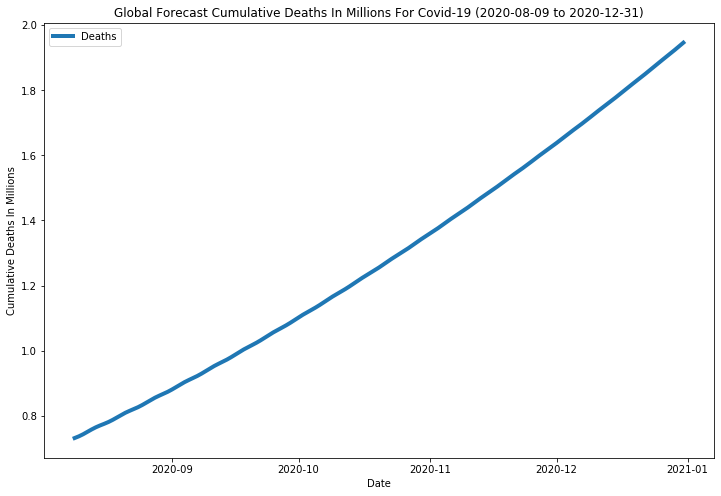

In [148]:
# Lets visualize that.
predict_deaths(forecast_df, 'Global')

ARIMA thinks that this is going to keep on going. I can certainly see why. There is nothing in the dataset that says it will do anything other than what it is doing here, which is heading up and to the right very rapidly. 

<a id='a4'></a>
### Answer to Question 4

> We developed 2 models. The first was based on trigonometry. This yielded an answer of approximately 827,000 people will die by the end of 2020. I am not updating this "model". I did the calculations as of May 5, 2020. I also created a more sophisticated ARIMA model. This predicts ~ 1 million people will not make it to 2021. These numbers will change if you rerun the notebook with the most recent data. The model was incredibly accurate in its test vs prediction scores. I think this is because the math of a pandemic is so simple. It is easy for the model to learn it. Lets hope that neither model is correct. However, I have a very bad feeling.

<a id='conclusions'></a>
## Results and Conclusions

> We answered 4 questions in this notebook. Please click on these links to look at those answers.
<li style="margin-left: 40px"><a href="#a1">Answer To Q1</a></li>
<li style="margin-left: 40px"><a href="#a2">Answer To Q2</a></li>
<li style="margin-left: 40px"><a href="#a3">Answer To Q3</a></li>
<li style="margin-left: 40px"><a href="#a4">Answer To Q4</a></li>

> 24 of 28 countries (that met the cutoffs) have a flattening of the curve presently. That is VERY encouraging.

> It is surprising to see rich countries struggle with this virus. There is a saying that democracies get the type of leadership that they deserve. Hopefully this is a wake up call that electing incompetent politicians with massive character flaws to the highest office in the land can and does cause death. This time those deaths are being counted. They are not hidden in Syria, Afghanistan, etc. They are right in the home countries that have weak leadership.

> Including the Median Per Capita Income and the Transparency International score was helpful in terms of creating cutoffs that made sense.  

> One sobering thought here is that there are 203 unique Alpha_3 codes in this dataset. That corresponds to 203 Country_Regions. We are only looking at 28 of them. This is because of the concern over the honesty of the data. In otherwords the challenge that we are looking at here is only the tip of the iceberg.

<a id='limitations'></a>
### Limitations

Generally speaking I believe the reporting on the John Hopkins data is extremely suspect. This is due to political and on the ground issues. Politicians do not want to be accused of doing less than a great job, especially when it is obvious they are doing anything but a great job. Many countries simply do not have the infrastructure, systems, etc. to care for the sick and to report. People are dying and they are not reporting those statistics. Cases are happening and they do not have testing. It is likely that the only reasonable data that you will get and it will be still be grossly under reported in terms of actual cases will be from the western democracies. However, the Transparency International score I have included gives me some confidence for all of the findings in this notebook. 

<a id='deploy'></a>
## Deploy

> Update the John Holkins, Covid-19 data https://github.com/CSSEGISandData/COVID-19 by refreshing your local copy of the GitHub repository. The ARIMA model has been hyper parameter tuned, stored on disk and is ready to go. There is a forecasting module included for this dataset that can be ran at any time. It remains to be seen whether or not its predictions will be accurate. For additonal information please refer to the ReadMe.